In [2]:
import datetime as dt
import pandas as pd
import itertools

import numpy as np
import scipy.io as io
from scipy import stats
import os
import sys
sys.path.append("/home/barkni/workspace/esg-utils/esg_utils/data")
sys.path.append("/home/barkni/workspace/esg-utils/esg_utils/helper")

import gs_dask
import gs_db
import kdata

import matplotlib.pyplot as plt
import seaborn as sns
import warnings

#import cdt
from cdt.independence.stats import MIRegression, PearsonCorrelation, SpearmanCorrelation, AdjMI
import networkx as nt
from algorithmx import jupyter_canvas

No GPU automatically detected. Setting SETTINGS.GPU to 0, and SETTINGS.NJOBS to cpu_count.


In [3]:
from secref import mapping
from kdata import data as kd
from kdata import gics as gc
from kdata import utils as ku

In [4]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [5]:
import statsmodels.api as sm

In [6]:
import math

In [142]:
# TO OUTPUT NOTEBOOK IN HTML WITH NO CODE BLOCKS SHOWN:
# jupyter nbconvert --to html --no-input Thematic_Ratings.ipynb

## Data Collection

#### This section of the notebook contains the functions that query the different datasets. This section is intentionally not included in this output. 

In [8]:
COLUMN_MAPPER = {
    'file_date' : 'date_str',
    'issuer_cusip': 'cusip',
    'issuer_sedol': 'sedol',
    'issuer_isin': 'isin'
}

In [9]:
def get_overall_ratings_data(dt):

    #print('Getting Overall Ratings Data...')
    # connect to the database and query the data
    with gs_db.get_hive_conn('prod') as con:
        sql = """select file_date, issuer_name, issuer_cusip, issuer_sedol, issuer_isin, 
                 human_capital_theme_weight, human_capital_theme_score, human_capital_dev_weight, human_capital_dev_score,
                 human_capital_dev_exp_score, human_capital_dev_mgmt_score 
                 from goldmansachs_esgratingssocial
                 where file_date = '{file_date}'
                 and data_year = '{year}'
                 """.format(
                            file_date=dt.strftime('%Y%m%d'),
                            year=dt.strftime('%Y'))
        E = pd.read_sql(sql,con=con)
    
    # rename the columns
    E.columns = E.columns.str.replace("goldmansachs_esgratingssocial.","")

    return E

In [10]:
def get_overall_ratings_data_TimeSeries(start_dt, end_dt):
    
    #print('Getting Overall Ratings Data...')
    # connect to the database and query the data
    with gs_db.get_hive_conn('prod') as con:
        sql = """select distinct file_date, issuer_name, issuer_cusip, issuer_sedol, issuer_isin, 
                 human_capital_theme_weight, human_capital_theme_score, human_capital_dev_weight, human_capital_dev_score,
                 human_capital_dev_exp_score, human_capital_dev_mgmt_score 
                 from goldmansachs_esgratingssocial
                 where file_date >= '{st_dt}' and file_date <= '{e_dt}'
                 and data_year >= '{s_year}' and data_year <= '{e_year}'
                 """.format(
                            st_dt=start_dt.strftime('%Y%m%d'),
                            e_dt=end_dt.strftime('%Y%m%d'),
                            s_year=start_dt.strftime('%Y'),
                            e_year=end_dt.strftime('%Y'))
        E = pd.read_sql(sql,con=con)
    
    # rename the columns
    E.columns = E.columns.str.replace("goldmansachs_esgratingssocial.","")

    return E

In [11]:
def get_quant_HCM_data(dt):

    #print('Getting HCM Related Data...')
    # connect to the database and query the data
    with gs_db.get_hive_conn('prod') as con:
        sql = """select file_date, issuer_name, issuer_cusip, issuer_sedol, issuer_isin, 
                 workforce_part_time_over_20pct_nm, women_exec_mgmt_pct_recent, women_workforce_pct_recent, 
                 emp_turnover_annual_pct_recent, prof_dev_train_hours_per_emp_recent, women_senior_mgmt_pct_recent,
                 human_capital_dev_med_risk_bus_pct, human_capital_dev_high_risk_bus_pct
                 from goldmansachs_esg_metrics
                 where file_date = '{file_date}'
                 and data_year = '{year}'
                 """.format(
                            file_date=dt.strftime('%Y%m%d'),
                            year=dt.strftime('%Y'))
        E = pd.read_sql(sql,con=con)
    
    # rename the columns
    E.columns = E.columns.str.replace("goldmansachs_esg_metrics.","")

    return E

In [12]:
def get_policy_HCM_data(dt):

    #print('Getting HCM Related Data...')
    # connect to the database and query the data
    with gs_db.get_hive_conn('prod') as con:
        sql = """select file_date, issuer_name, issuer_cusip, issuer_sedol, issuer_isin, 
                 prof_dev_degree_programs, prof_dev_train_leader_manag
                 from goldmansachs_esg_metrics
                 where file_date = '{file_date}'
                 and data_year = '{year}'
                 """.format(
                            file_date=dt.strftime('%Y%m%d'),
                            year=dt.strftime('%Y'))
        E = pd.read_sql(sql,con=con)
    
    # rename the columns
    E.columns = E.columns.str.replace("goldmansachs_esg_metrics.","")

    return E

In [13]:
def get_quant_HCM_data_TimeSeries(start_dt, end_dt):

    #print('Getting HCM Related Data...')
    # connect to the database and query the data
        
    with gs_db.get_hive_conn('prod') as con:
        sql = """select distinct file_date, issuer_name, issuer_cusip, issuer_sedol, issuer_isin, 
                 workforce_part_time_over_20pct_nm, women_exec_mgmt_pct_recent, women_workforce_pct_recent, 
                 emp_turnover_annual_pct_recent, prof_dev_train_hours_per_emp_recent, women_senior_mgmt_pct_recent,
                 human_capital_dev_med_risk_bus_pct, human_capital_dev_high_risk_bus_pct
                 from goldmansachs_esg_metrics
                 where file_date >= '{st_dt}' and file_date <= '{e_dt}'
                 and data_year >= '{s_year}' and data_year <= '{e_year}'
                 """.format(
                            st_dt=start_dt.strftime('%Y%m%d'),
                            e_dt=end_dt.strftime('%Y%m%d'),
                            s_year=start_dt.strftime('%Y'),
                            e_year=end_dt.strftime('%Y'))
        E = pd.read_sql(sql,con=con)
    
    # rename the columns
    E.columns = E.columns.str.replace("goldmansachs_esg_metrics.","")

    return E

#### Pull Data PIT:

In [14]:
hcm_data_raw = get_quant_HCM_data(dt.date(2022,8,31))

In [15]:
hcm_policy_raw = get_policy_HCM_data(dt.date(2022,8,31))

In [16]:
ratings_data_raw = get_overall_ratings_data(dt.date(2022,8,31))

#### Since data was queried directly from databases, clean samples of each were created and provided separately. 

In [138]:
hcm_data_raw.drop_duplicates(subset=['issuer_name']).head(50).to_csv("RAW_hcm_quant_data.csv")

In [139]:
hcm_policy_raw.drop_duplicates(subset=['issuer_name']).head(50).to_csv("RAW_hcm_policy_data.csv")

In [140]:
ratings_data_raw.drop_duplicates(subset=['issuer_name']).head(50).to_csv("RAW_third_party_ratings_data.csv")

#### Pull TimeSeries of Data:

In [23]:
#start_date = dt.date(2022,8,28)
#end_date =  dt.date(2022,8,31)

In [24]:
#hcm_data_raw_ts = get_quant_HCM_data_TimeSeries(start_date, end_date)

In [25]:
#ratings_data_raw_ts = get_overall_ratings_data_TimeSeries(start_date, end_date)

## Overall Ratings Data Processing

In [17]:
ratings_themes = ["human_capital_theme_weight", "human_capital_theme_score", "human_capital_dev_weight",
                  "human_capital_dev_score", "human_capital_dev_exp_score", "human_capital_dev_mgmt_score"]

In [18]:
ratings_data = ratings_data_raw.dropna()
ratings_data = ratings_data.drop_duplicates(subset=['issuer_name'])

In [19]:
ratings_data[ratings_themes].describe()

human_capital_theme_weight  human_capital_theme_score  \
count                14235.000000               14235.000000   
mean                    19.730032                   4.595265   
std                      7.752800                   2.030963   
min                      0.000000                   0.000000   
25%                     15.000000                   3.100000   
50%                     20.000000                   4.600000   
75%                     25.000000                   6.000000   
max                     56.000000                  10.000000   

       human_capital_dev_weight  human_capital_dev_score  \
count              14235.000000             14235.000000   
mean                  10.684370                 4.789055   
std                   10.750471                 2.274230   
min                    0.000000                 0.000000   
25%                    0.000000                 3.100000   
50%                   13.000000                 4.800000   
75%                   20.000000                 6.400000   
max                   35.000000                10.000000   

       human_capital_dev_exp_score  human_capital_dev_mgmt_score  
count                 14235.000000                  14235.000000  
mean                      6.700808                      4.499747  
std                       1.732765                      2.021378  
min                       0.000000                      0.000000  
25%                       5.700000                      3.100000  
50%                       7.000000                      4.500000  
75%                       8.100000                      6.200000  
max                      10.000000                     10.000000

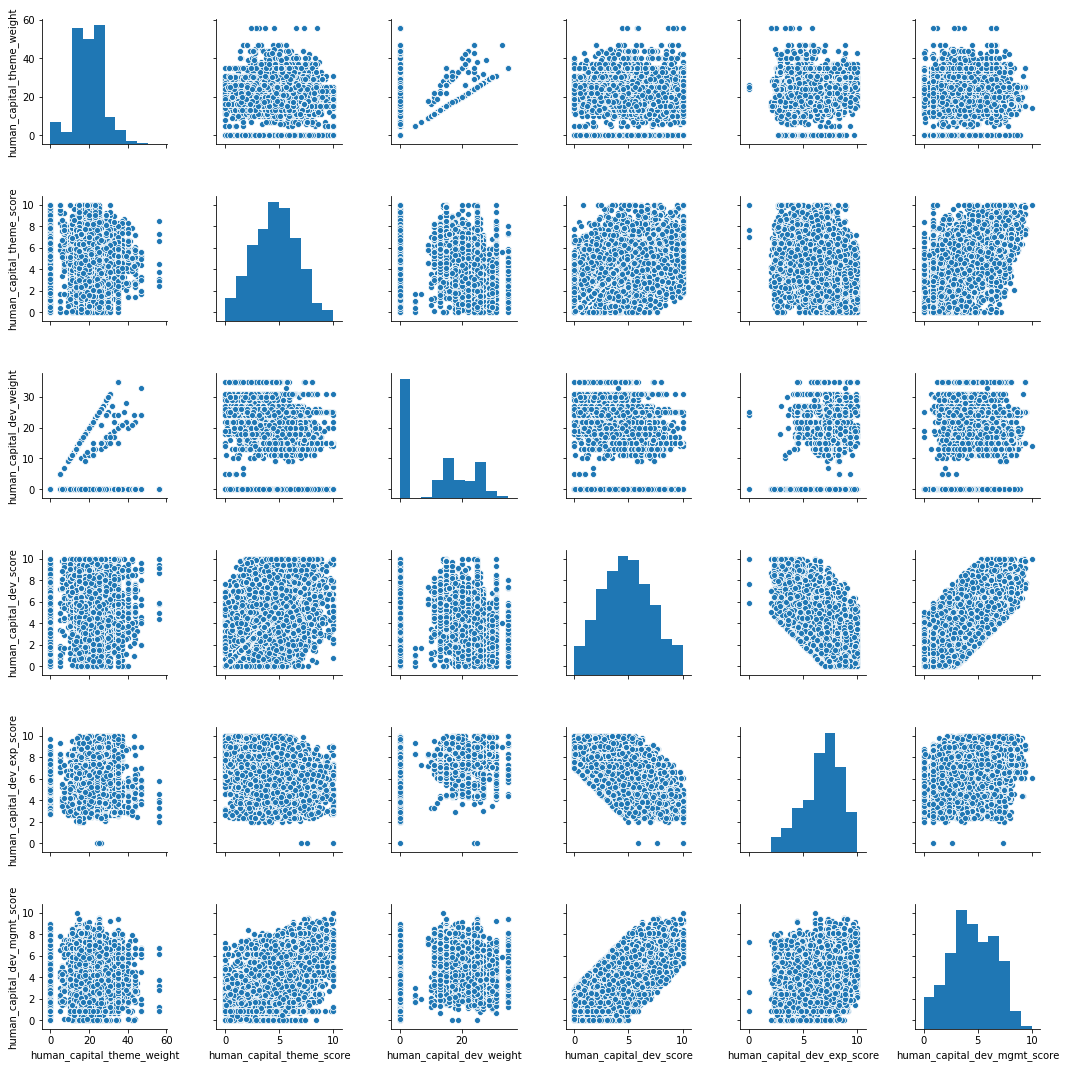

In [20]:
sns.pairplot(ratings_data[ratings_themes])
plt.show()

In [21]:
inertia_values = []

for i in range(1, 20):
    kmeans_model = KMeans(n_clusters=i, random_state=0)
    #pca_model = PCA(i)
    
    kmeans = kmeans_model.fit(ratings_data[ratings_themes])
    #pca_df = pca.fit_transform(kmeans_df)
    
    inertia_values.append(kmeans.inertia_)
    
marginal_inertia_values = np.diff(inertia_values)*-1 / inertia_values[0]

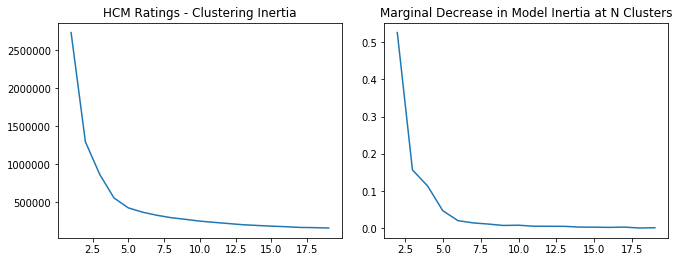

In [22]:
fig, axs = plt.subplots(1, 2, figsize = (10,4) )

axs[0].plot(range(1, 20), inertia_values)
axs[0].set_title('HCM Ratings - Clustering Inertia')

axs[1].plot(range(2, 20), marginal_inertia_values)
axs[1].set_title('Marginal Decrease in Model Inertia at N Clusters')

fig.tight_layout(pad=2)
plt.show()

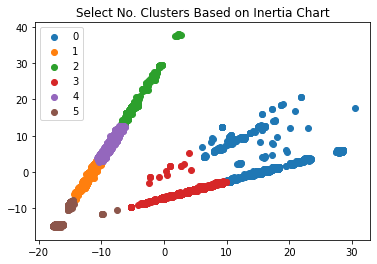

In [23]:
#filter rows of original data
num_clusters = 6;
kmeans_model = KMeans(n_clusters=num_clusters, random_state=0)
pca_model = PCA(num_clusters)
    
kmeans = kmeans_model.fit_predict(ratings_data[ratings_themes])
pca_df = pca_model.fit_transform(ratings_data[ratings_themes])

cluster_data = []

for i in range(0, num_clusters):
    cluster_data.append(pca_df[kmeans == i])

#Plotting the results
for i in range(0, num_clusters):
    cluster_data.append(pca_df[kmeans == i])
    plt.scatter(cluster_data[i][:,0], cluster_data[i][:,1] , label = i)

plt.title('Select No. Clusters Based on Inertia Chart')
plt.legend()
plt.show()

### Iterative Clustering of Data

In [24]:
num_clusters = len(ratings_themes);

In [25]:
num_cols = int(num_clusters ** (1/2))

num_rows = num_clusters // num_cols 

#     EDIT for correct number of rows:
#     If one additional row is necessary -> add one:

if num_clusters % num_cols != 0:
    num_rows += 1

# Create a Position index

Position = range(1,num_clusters + 1)

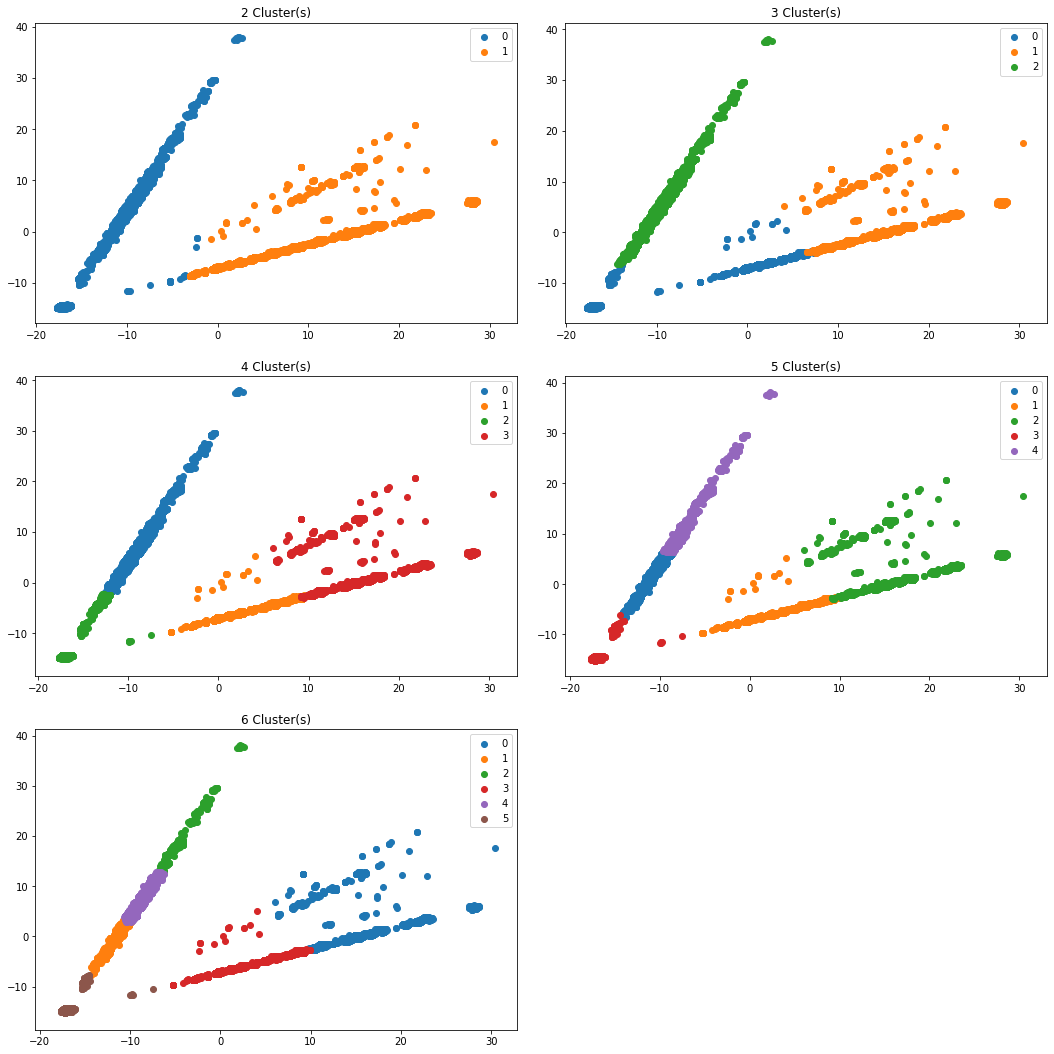

In [26]:
fig = plt.figure(1, figsize=(15,15))
for k in range(2, num_clusters+1):
    ax = fig.add_subplot(num_rows,num_cols,Position[k-2])
 
    kmeans_model = KMeans(n_clusters=k, random_state=0)
    pca_model = PCA(k)

    kmeans = kmeans_model.fit_predict(ratings_data[ratings_themes])
    pca_df = pca_model.fit_transform(ratings_data[ratings_themes])

    #Plotting the results
    for i in range(0, k):
        cluster_data = pca_df[kmeans == i]
        ax.scatter(cluster_data[:,0], cluster_data[:,1] , label = i)
        ax.set_title(str(k)+' Cluster(s)')
        ax.legend()
    
fig.tight_layout(pad=2)
plt.show()

## HCM Data Processing

In [27]:
hcm_themes_full = ["workforce_part_time_over_20pct_nm", "women_exec_mgmt_pct_recent", "women_workforce_pct_recent", 
                   "emp_turnover_annual_pct_recent", "prof_dev_train_hours_per_emp_recent", "women_senior_mgmt_pct_recent",
                   "human_capital_dev_med_risk_bus_pct", "human_capital_dev_high_risk_bus_pct"]


hcm_themes = [ "women_exec_mgmt_pct_recent", "women_workforce_pct_recent", "emp_turnover_annual_pct_recent",
               "prof_dev_train_hours_per_emp_recent", "women_senior_mgmt_pct_recent", "human_capital_dev_high_risk_bus_pct"]


In [28]:
hcm_data_no_dupes = hcm_data_raw.drop_duplicates(subset=['issuer_name'])
hcm_data_no_dupes = hcm_data_no_dupes.drop(hcm_data_no_dupes[hcm_data_no_dupes.women_senior_mgmt_pct_recent > 100].index)
hcm_data_no_dupes = hcm_data_no_dupes.drop(hcm_data_no_dupes[hcm_data_no_dupes.women_exec_mgmt_pct_recent > 100].index)
hcm_data_no_dupes = hcm_data_no_dupes.drop(hcm_data_no_dupes[hcm_data_no_dupes.women_workforce_pct_recent > 100].index)
hcm_data_no_dupes = hcm_data_no_dupes.drop(hcm_data_no_dupes[hcm_data_no_dupes.human_capital_dev_high_risk_bus_pct > 100].index)

In [29]:
hcm_data_no_dupes.describe()

workforce_part_time_over_20pct_nm  women_exec_mgmt_pct_recent  \
count                        9762.000000                 7108.000000   
mean                           -0.035239                   17.205867   
std                             0.184392                   17.426977   
min                            -1.000000                    0.000000   
25%                             0.000000                    0.000000   
50%                             0.000000                   14.300000   
75%                             0.000000                   27.300000   
max                             0.000000                  100.000000   

       women_workforce_pct_recent  emp_turnover_annual_pct_recent  \
count                 4641.000000                     2650.000000   
mean                    34.834044                       11.519623   
std                     18.473922                       10.338212   
min                      0.000000                        0.000000   
25%                     20.800000                        5.000000   
50%                     34.000000                        9.000000   
75%                     48.000000                       15.000000   
max                    100.000000                      133.000000   

       prof_dev_train_hours_per_emp_recent  women_senior_mgmt_pct_recent  \
count                          2318.000000                   1237.000000   
mean                             30.897006                     20.489491   
std                              37.585408                     16.981514   
min                               0.030000                      0.000000   
25%                              11.800000                      6.300000   
50%                              21.000000                     18.900000   
75%                              37.247500                     33.300000   
max                             682.030000                    100.000000   

       human_capital_dev_med_risk_bus_pct  human_capital_dev_high_risk_bus_pct  
count                        10917.000000                         10917.000000  
mean                            46.010725                            44.745759  
std                             46.716790                            47.220603  
min                              0.000000                             0.000000  
25%                              0.000000                             0.000000  
50%                             24.310000                            13.100000  
75%                            100.000000                           100.000000  
max                            100.000000                           100.000000

In [30]:
hcm_themes

['women_exec_mgmt_pct_recent',
 'women_workforce_pct_recent',
 'emp_turnover_annual_pct_recent',
 'prof_dev_train_hours_per_emp_recent',
 'women_senior_mgmt_pct_recent',
 'human_capital_dev_high_risk_bus_pct']

In [31]:
hcm_data = hcm_data_raw.drop(hcm_data_raw[hcm_data_raw.women_senior_mgmt_pct_recent > 100].index)
hcm_data = hcm_data.drop(hcm_data[hcm_data.women_exec_mgmt_pct_recent > 100].index)
hcm_data = hcm_data.drop(hcm_data[hcm_data.women_workforce_pct_recent > 100].index)
hcm_data = hcm_data.drop(hcm_data[hcm_data.human_capital_dev_high_risk_bus_pct > 100].index)
hcm_data = hcm_data.drop_duplicates(subset=['issuer_name'])

In [32]:
hcm_data[hcm_themes].describe()

women_exec_mgmt_pct_recent  women_workforce_pct_recent  \
count                 7108.000000                 4641.000000   
mean                    17.205867                   34.834044   
std                     17.426977                   18.473922   
min                      0.000000                    0.000000   
25%                      0.000000                   20.800000   
50%                     14.300000                   34.000000   
75%                     27.300000                   48.000000   
max                    100.000000                  100.000000   

       emp_turnover_annual_pct_recent  prof_dev_train_hours_per_emp_recent  \
count                     2650.000000                          2318.000000   
mean                        11.519623                            30.897006   
std                         10.338212                            37.585408   
min                          0.000000                             0.030000   
25%                          5.000000                            11.800000   
50%                          9.000000                            21.000000   
75%                         15.000000                            37.247500   
max                        133.000000                           682.030000   

       women_senior_mgmt_pct_recent  human_capital_dev_high_risk_bus_pct  
count                   1237.000000                         10917.000000  
mean                      20.489491                            44.745759  
std                       16.981514                            47.220603  
min                        0.000000                             0.000000  
25%                        6.300000                             0.000000  
50%                       18.900000                            13.100000  
75%                       33.300000                           100.000000  
max                      100.000000                           100.000000

In [33]:
hcm_data = hcm_data.dropna()
hcm_data = hcm_data.drop_duplicates(subset=['issuer_name'])

In [34]:
hcm_data[hcm_themes].describe()

women_exec_mgmt_pct_recent  women_workforce_pct_recent  \
count                  237.000000                  237.000000   
mean                    17.457342                   36.549789   
std                     18.066189                   18.636729   
min                      0.000000                    1.700000   
25%                      0.000000                   21.500000   
50%                     14.600000                   36.100000   
75%                     28.600000                   52.000000   
max                     80.000000                   78.500000   

       emp_turnover_annual_pct_recent  prof_dev_train_hours_per_emp_recent  \
count                      237.000000                           237.000000   
mean                        10.915612                            31.084979   
std                          9.481541                            26.832484   
min                          0.000000                             1.210000   
25%                          5.000000                            13.000000   
50%                          9.000000                            23.350000   
75%                         14.000000                            40.000000   
max                         70.000000                           173.000000   

       women_senior_mgmt_pct_recent  human_capital_dev_high_risk_bus_pct  
count                    237.000000                           237.000000  
mean                      23.013924                            41.956667  
std                       15.846943                            45.000002  
min                        0.000000                             0.000000  
25%                       11.100000                             0.000000  
50%                       23.100000                            17.210000  
75%                       33.300000                            99.990000  
max                       66.900000                           100.000000

In [35]:
hcm_data[hcm_themes_full].describe()

workforce_part_time_over_20pct_nm  women_exec_mgmt_pct_recent  \
count                         237.000000                  237.000000   
mean                           -0.059072                   17.457342   
std                             0.236258                   18.066189   
min                            -1.000000                    0.000000   
25%                             0.000000                    0.000000   
50%                             0.000000                   14.600000   
75%                             0.000000                   28.600000   
max                             0.000000                   80.000000   

       women_workforce_pct_recent  emp_turnover_annual_pct_recent  \
count                  237.000000                      237.000000   
mean                    36.549789                       10.915612   
std                     18.636729                        9.481541   
min                      1.700000                        0.000000   
25%                     21.500000                        5.000000   
50%                     36.100000                        9.000000   
75%                     52.000000                       14.000000   
max                     78.500000                       70.000000   

       prof_dev_train_hours_per_emp_recent  women_senior_mgmt_pct_recent  \
count                           237.000000                    237.000000   
mean                             31.084979                     23.013924   
std                              26.832484                     15.846943   
min                               1.210000                      0.000000   
25%                              13.000000                     11.100000   
50%                              23.350000                     23.100000   
75%                              40.000000                     33.300000   
max                             173.000000                     66.900000   

       human_capital_dev_med_risk_bus_pct  human_capital_dev_high_risk_bus_pct  
count                          237.000000                           237.000000  
mean                            49.967046                            41.956667  
std                             44.978101                            45.000002  
min                              0.000000                             0.000000  
25%                              0.000000                             0.000000  
50%                             51.110000                            17.210000  
75%                            100.000000                            99.990000  
max                            100.000000                           100.000000

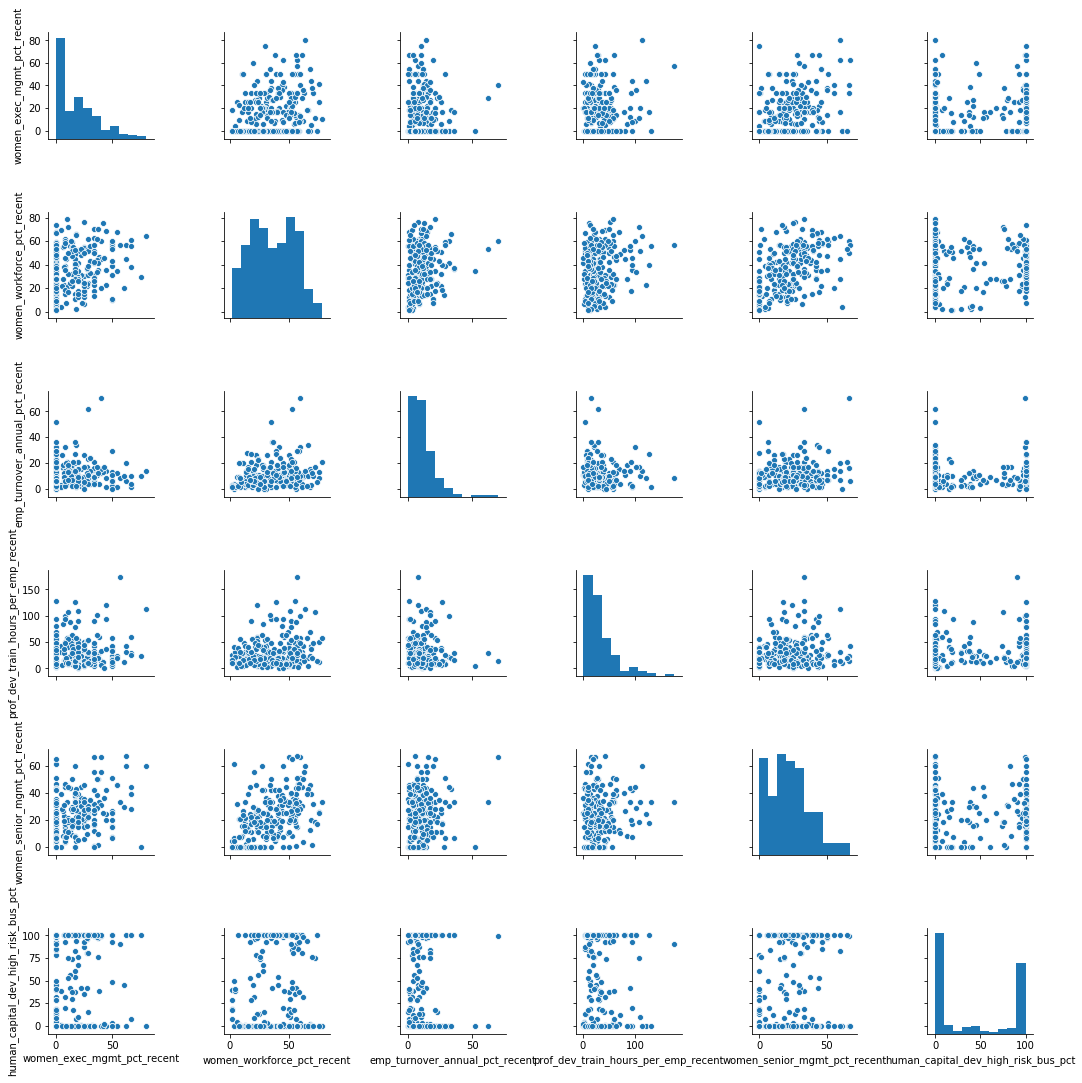

In [36]:
sns.pairplot(hcm_data[hcm_themes])
plt.show()

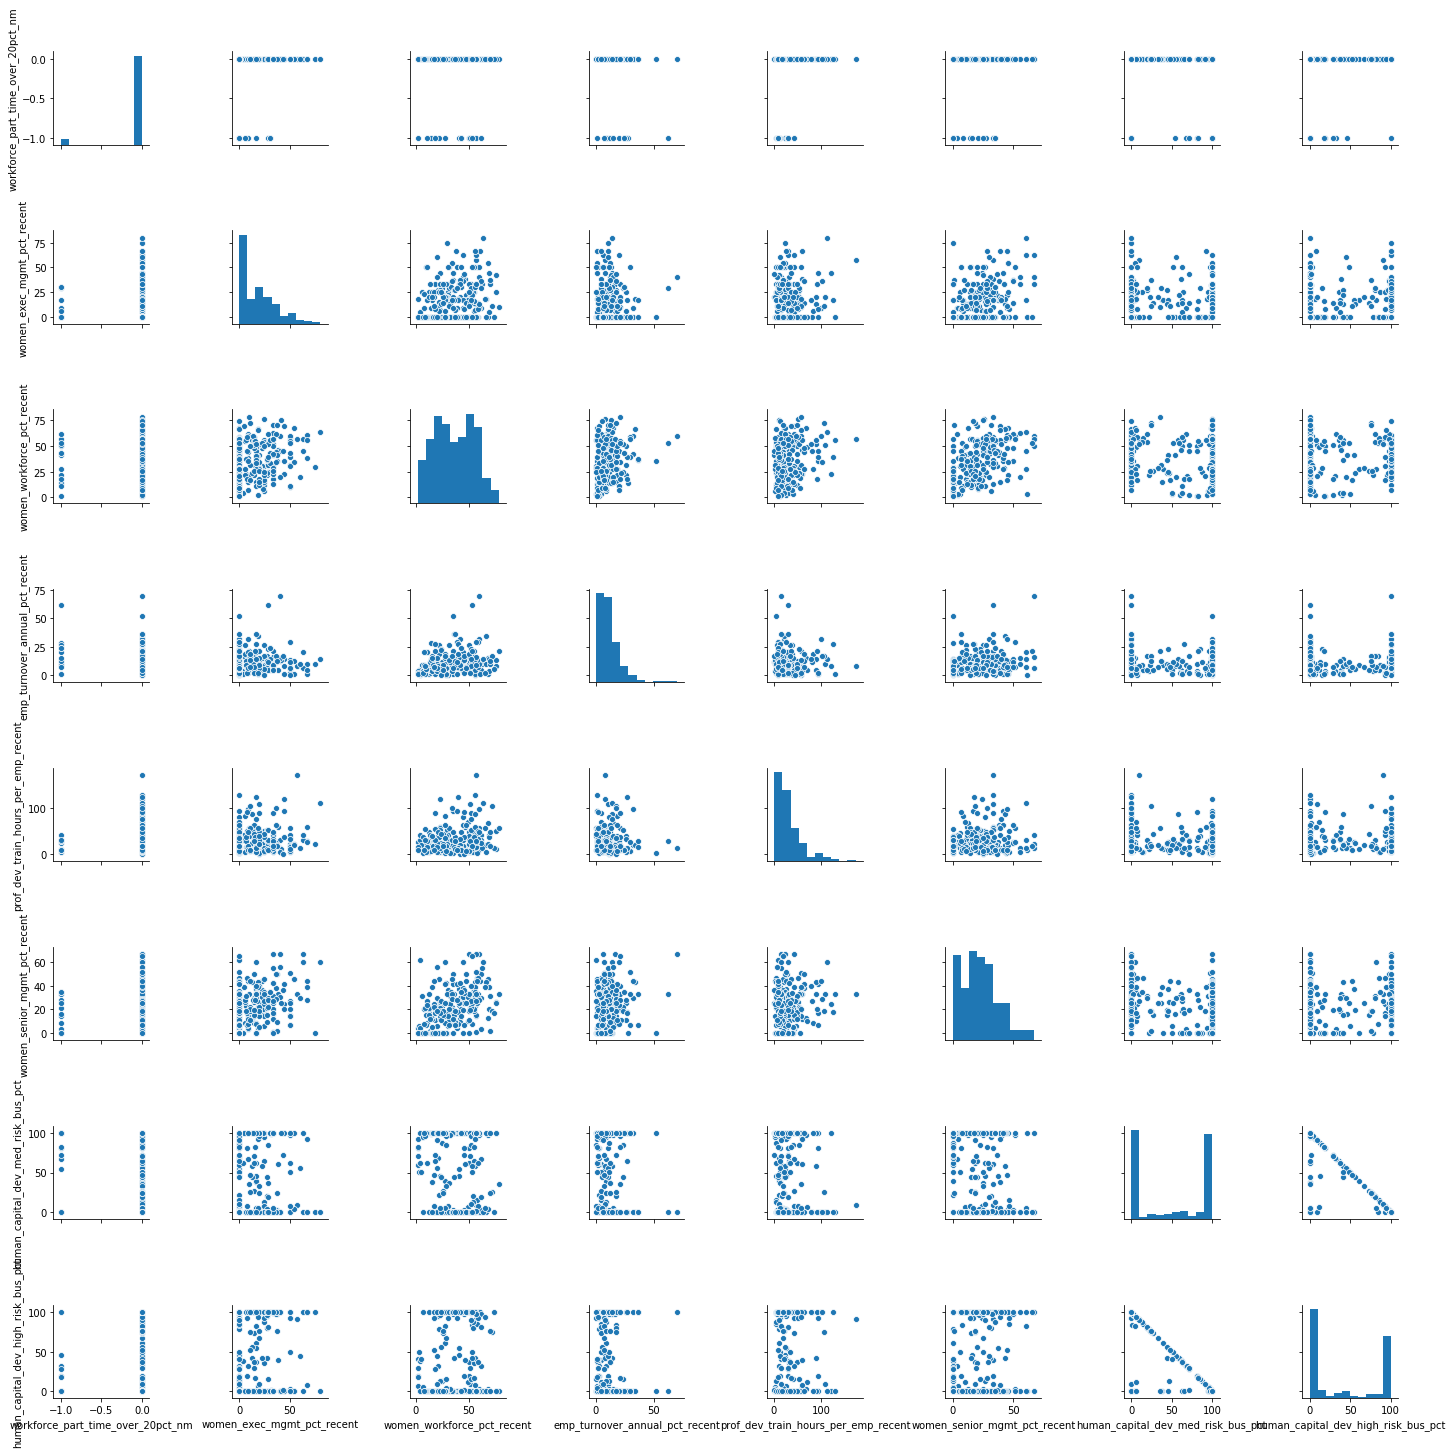

In [37]:
sns.pairplot(hcm_data[hcm_themes_full])
plt.show()

In [38]:
inertia_values = []

for i in range(1, 20):
    kmeans_model = KMeans(n_clusters=i, random_state=0)
    #pca_model = PCA(i)
    
    kmeans = kmeans_model.fit(hcm_data[hcm_themes])
    #pca_df = pca.fit_transform(kmeans_df)
    
    inertia_values.append(kmeans.inertia_)

marginal_inertia_values = np.diff(inertia_values)*-1 / inertia_values[0]

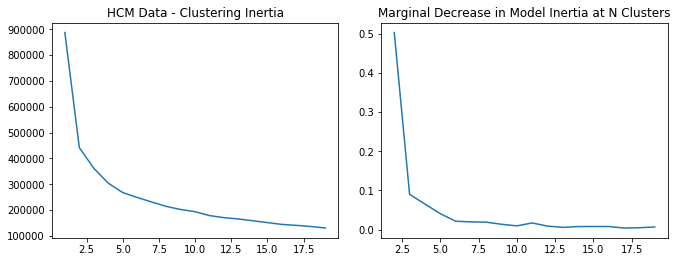

In [39]:
fig, axs = plt.subplots(1, 2, figsize = (10,4) )

axs[0].plot(range(1, 20), inertia_values)
axs[0].set_title('HCM Data - Clustering Inertia')

axs[1].plot(range(2, 20), marginal_inertia_values)
axs[1].set_title('Marginal Decrease in Model Inertia at N Clusters')

fig.tight_layout(pad=2)
plt.show()

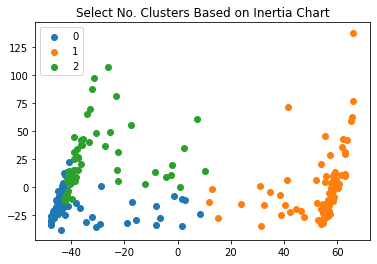

In [40]:
#filter rows of original data
num_clusters = 3;

kmeans_model = KMeans(n_clusters=num_clusters, random_state=0)
pca_model = PCA(num_clusters)
    
kmeans = kmeans_model.fit_predict(hcm_data[hcm_themes])
pca_df = pca_model.fit_transform(hcm_data[hcm_themes])

cluster_data = []

for i in range(0, num_clusters):
    cluster_data.append(pca_df[kmeans == i])

#Plotting the results
for i in range(0, num_clusters):
    cluster_data.append(pca_df[kmeans == i])
    plt.scatter(cluster_data[i][:,0], cluster_data[i][:,1] , label = i)
    
plt.title('Select No. Clusters Based on Inertia Chart')
plt.legend()
plt.show()

### Iterative Clustering of Data

In [41]:
num_clusters = len(hcm_themes);

In [42]:
num_cols = int(num_clusters ** (1/2))

num_rows = num_clusters // num_cols 

#     EDIT for correct number of rows:
#     If one additional row is necessary -> add one:

if num_clusters % num_cols != 0:
    num_rows += 1

# Create a Position index

Position = range(1,num_clusters + 1)

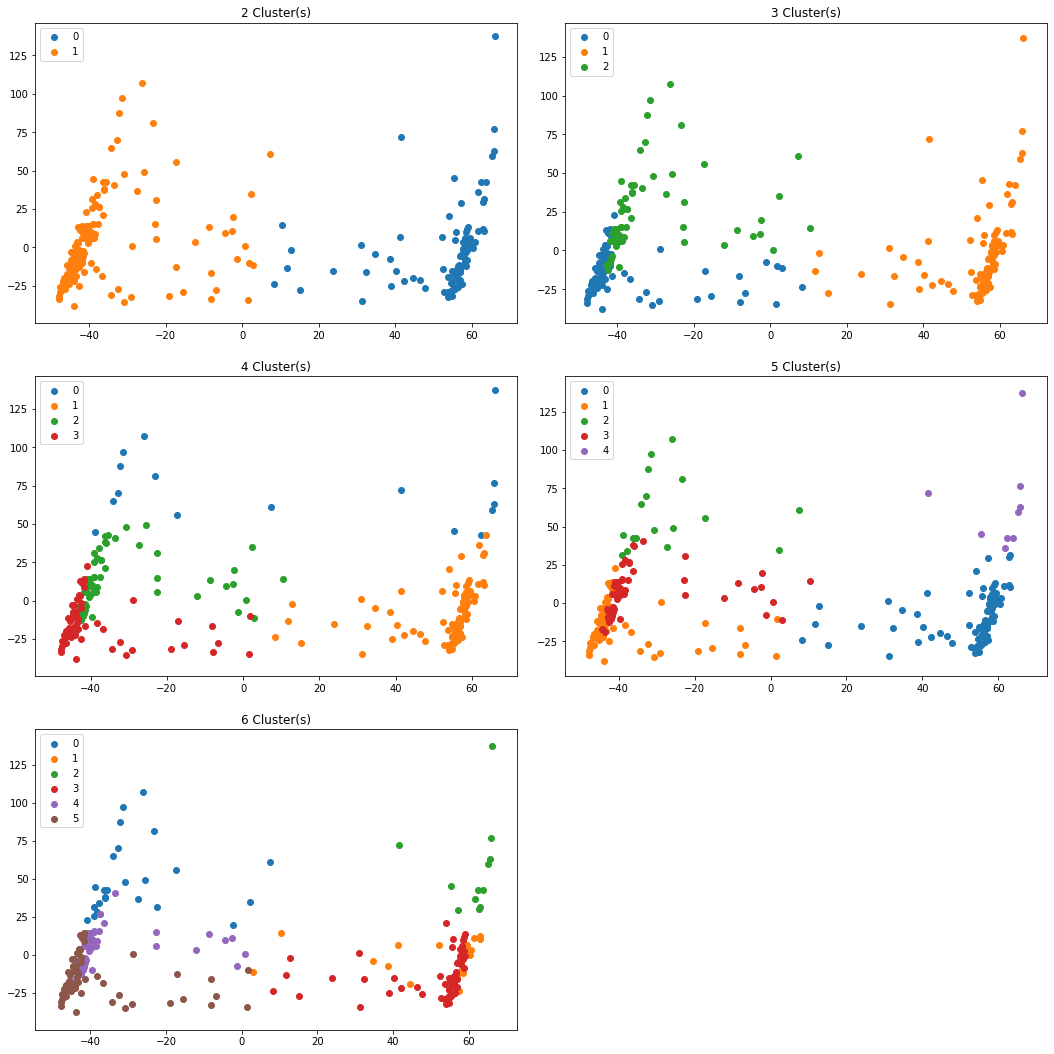

In [43]:
fig = plt.figure(1, figsize=(15,15))
for k in range(2, num_clusters+1):
    ax = fig.add_subplot(num_rows,num_cols,Position[k-2])
 
    kmeans_model = KMeans(n_clusters=k, random_state=0)
    pca_model = PCA(k)

    kmeans = kmeans_model.fit_predict(hcm_data[hcm_themes])
    pca_df = pca_model.fit_transform(hcm_data[hcm_themes])

    #Plotting the results
    for i in range(0, k):
        cluster_data = pca_df[kmeans == i]
        ax.scatter(cluster_data[:,0], cluster_data[:,1] , label = i)
        ax.set_title(str(k)+' Cluster(s)')
        ax.legend()
    
fig.tight_layout(pad=2)
plt.show()

## Calculate Work Force Sophistication Score

In [44]:
score_hcm_themes = hcm_themes + ["score"]
score_hcm_themes = [e for e in score_hcm_themes if e not in ('human_capital_dev_high_risk_bus_pct', 'human_capital_dev_med_risk_bus_pct')]

In [45]:
non_workforce_themes = [e for e in score_hcm_themes if e not in ('score')]

In [46]:
test = hcm_data_no_dupes.copy()

In [48]:

test["low"] = 100 - (hcm_data_no_dupes["human_capital_dev_med_risk_bus_pct"] + hcm_data_no_dupes["human_capital_dev_high_risk_bus_pct"])
test["med"] = hcm_data_no_dupes["human_capital_dev_med_risk_bus_pct"]
test["high"] = hcm_data_no_dupes["human_capital_dev_high_risk_bus_pct"]
test["score"] = (0 * test["low"]) + (.5  * test["med"]) +(1 * test["high"])


In [49]:
test.describe()

workforce_part_time_over_20pct_nm  women_exec_mgmt_pct_recent  \
count                        9762.000000                 7108.000000   
mean                           -0.035239                   17.205867   
std                             0.184392                   17.426977   
min                            -1.000000                    0.000000   
25%                             0.000000                    0.000000   
50%                             0.000000                   14.300000   
75%                             0.000000                   27.300000   
max                             0.000000                  100.000000   

       women_workforce_pct_recent  emp_turnover_annual_pct_recent  \
count                 4641.000000                     2650.000000   
mean                    34.834044                       11.519623   
std                     18.473922                       10.338212   
min                      0.000000                        0.000000   
25%                     20.800000                        5.000000   
50%                     34.000000                        9.000000   
75%                     48.000000                       15.000000   
max                    100.000000                      133.000000   

       prof_dev_train_hours_per_emp_recent  women_senior_mgmt_pct_recent  \
count                          2318.000000                   1237.000000   
mean                             30.897006                     20.489491   
std                              37.585408                     16.981514   
min                               0.030000                      0.000000   
25%                              11.800000                      6.300000   
50%                              21.000000                     18.900000   
75%                              37.247500                     33.300000   
max                             682.030000                    100.000000   

       human_capital_dev_med_risk_bus_pct  \
count                        10917.000000   
mean                            46.010725   
std                             46.716790   
min                              0.000000   
25%                              0.000000   
50%                             24.310000   
75%                            100.000000   
max                            100.000000   

       human_capital_dev_high_risk_bus_pct           low           med  \
count                         10917.000000  10917.000000  10917.000000   
mean                             44.745759      9.243517     46.010725   
std                              47.220603     27.032061     46.716790   
min                               0.000000     -0.010000      0.000000   
25%                               0.000000      0.000000      0.000000   
50%                              13.100000      0.000000     24.310000   
75%                             100.000000      0.000000    100.000000   
max                             100.000000    100.000000    100.000000   

               high         score  
count  10917.000000  10917.000000  
mean      44.745759     67.751121  
std       47.220603     30.571952  
min        0.000000      0.000000  
25%        0.000000     50.000000  
50%       13.100000     55.080000  
75%      100.000000    100.000000  
max      100.000000    100.000000

invalid value encountered in greater_equal
invalid value encountered in less_equal


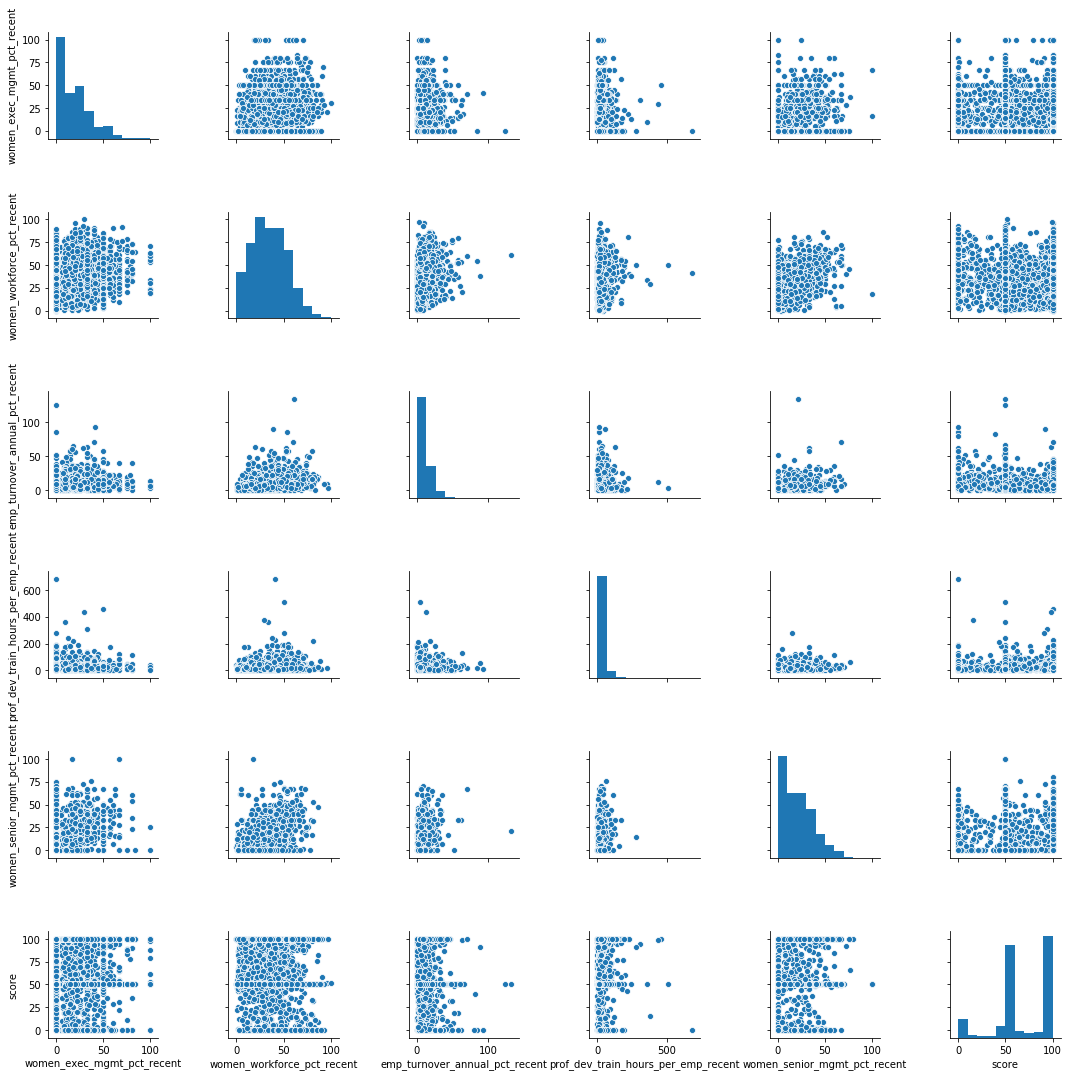

In [51]:
sns.pairplot(test[score_hcm_themes])
plt.show()

In [52]:
clean_hcm_scores = test.dropna()

In [53]:
clean_hcm_scores.describe()

workforce_part_time_over_20pct_nm  women_exec_mgmt_pct_recent  \
count                         237.000000                  237.000000   
mean                           -0.059072                   17.457342   
std                             0.236258                   18.066189   
min                            -1.000000                    0.000000   
25%                             0.000000                    0.000000   
50%                             0.000000                   14.600000   
75%                             0.000000                   28.600000   
max                             0.000000                   80.000000   

       women_workforce_pct_recent  emp_turnover_annual_pct_recent  \
count                  237.000000                      237.000000   
mean                    36.549789                       10.915612   
std                     18.636729                        9.481541   
min                      1.700000                        0.000000   
25%                     21.500000                        5.000000   
50%                     36.100000                        9.000000   
75%                     52.000000                       14.000000   
max                     78.500000                       70.000000   

       prof_dev_train_hours_per_emp_recent  women_senior_mgmt_pct_recent  \
count                           237.000000                    237.000000   
mean                             31.084979                     23.013924   
std                              26.832484                     15.846943   
min                               1.210000                      0.000000   
25%                              13.000000                     11.100000   
50%                              23.350000                     23.100000   
75%                              40.000000                     33.300000   
max                             173.000000                     66.900000   

       human_capital_dev_med_risk_bus_pct  \
count                          237.000000   
mean                            49.967046   
std                             44.978101   
min                              0.000000   
25%                              0.000000   
50%                             51.110000   
75%                            100.000000   
max                            100.000000   

       human_capital_dev_high_risk_bus_pct         low         med  \
count                           237.000000  237.000000  237.000000   
mean                             41.956667    8.076287   49.967046   
std                              45.000002   24.979332   44.978101   
min                               0.000000   -0.010000    0.000000   
25%                               0.000000    0.000000    0.000000   
50%                              17.210000    0.000000   51.110000   
75%                              99.990000    0.010000  100.000000   
max                             100.000000  100.000000  100.000000   

             high       score  
count  237.000000  237.000000  
mean    41.956667   66.940190  
std     45.000002   28.613392  
min      0.000000    0.000000  
25%      0.000000   50.000000  
50%     17.210000   58.605000  
75%     99.990000   99.990000  
max    100.000000  100.000000

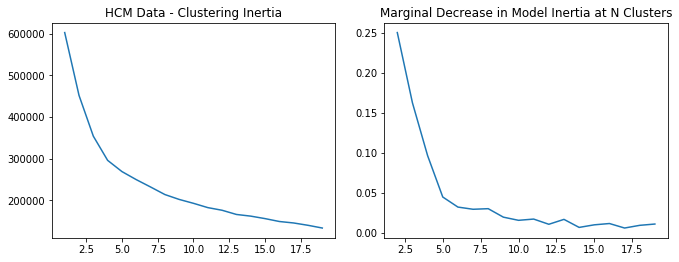

In [54]:
inertia_values = []

for i in range(1, 20):
    kmeans_model = KMeans(n_clusters=i, random_state=0)
    #pca_model = PCA(i)
    
    kmeans = kmeans_model.fit(clean_hcm_scores[score_hcm_themes])
    #pca_df = pca.fit_transform(kmeans_df)
    
    inertia_values.append(kmeans.inertia_)

marginal_inertia_values = np.diff(inertia_values)*-1 / inertia_values[0]

fig, axs = plt.subplots(1, 2, figsize = (10,4) )

axs[0].plot(range(1, 20), inertia_values)
axs[0].set_title('HCM Data - Clustering Inertia')

axs[1].plot(range(2, 20), marginal_inertia_values)
axs[1].set_title('Marginal Decrease in Model Inertia at N Clusters')

fig.tight_layout(pad=2)
plt.show()

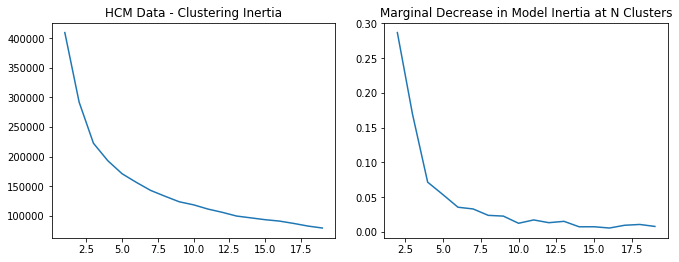

In [55]:
inertia_values = []

for i in range(1, 20):
    kmeans_model_no_wf = KMeans(n_clusters=i, random_state=0)
    #pca_model = PCA(i)
    
    kmeans_no_wf = kmeans_model_no_wf.fit(clean_hcm_scores[non_workforce_themes])
    #pca_df = pca.fit_transform(kmeans_df)
    
    inertia_values.append(kmeans_no_wf.inertia_)

marginal_inertia_values = np.diff(inertia_values)*-1 / inertia_values[0]

fig, axs = plt.subplots(1, 2, figsize = (10,4) )

axs[0].plot(range(1, 20), inertia_values)
axs[0].set_title('HCM Data - Clustering Inertia')

axs[1].plot(range(2, 20), marginal_inertia_values)
axs[1].set_title('Marginal Decrease in Model Inertia at N Clusters')

fig.tight_layout(pad=2)
plt.show()

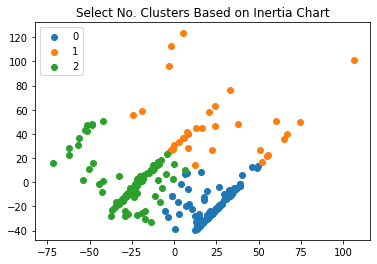

In [56]:
#filter rows of original data
num_clusters = 3;

kmeans_model = KMeans(n_clusters=num_clusters, random_state=0)
pca_model = PCA(num_clusters)
    
kmeans = kmeans_model.fit_predict(clean_hcm_scores[score_hcm_themes])
pca_df = pca_model.fit_transform(clean_hcm_scores[score_hcm_themes])

cluster_data = []

#Plotting the results
for i in range(0, num_clusters):
    cluster_data.append(pca_df[kmeans == i])
    plt.scatter(cluster_data[i][:,0], cluster_data[i][:,1] , label = i)
    
plt.title('Select No. Clusters Based on Inertia Chart')
plt.legend()
plt.show()

In [57]:
num_clusters = len(score_hcm_themes);

In [58]:
num_row = int(num_clusters ** (1/2))

num_cols = num_clusters // num_rows 

#     EDIT for correct number of rows:
#     If one additional row is necessary -> add one:

if num_clusters % num_row != 0:
    num_cols += 1

# Create a Position index

Position = range(1,num_clusters + 1)

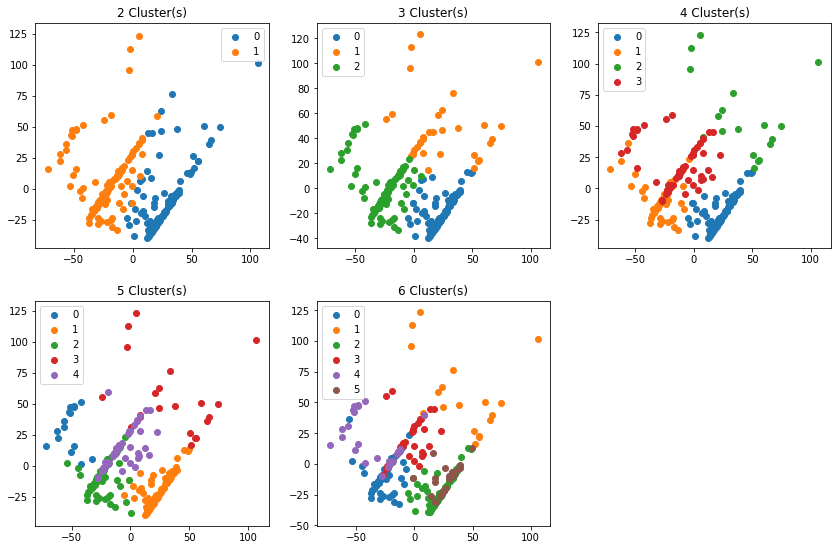

In [59]:
fig = plt.figure(1, figsize=(12,8))
for k in range(2, num_clusters+1):
    ax = fig.add_subplot(num_cols,num_rows,Position[k-2])
 
    kmeans_model = KMeans(n_clusters=k, random_state=0)
    pca_model = PCA(k)

    kmeans = kmeans_model.fit_predict(clean_hcm_scores[score_hcm_themes])
    pca_df = pca_model.fit_transform(clean_hcm_scores[score_hcm_themes])

    #Plotting the results
    for i in range(0, k):
        cluster_data = pca_df[kmeans == i]
        ax.scatter(cluster_data[:,0], cluster_data[:,1] , label = i)
        ax.set_title(str(k)+' Cluster(s)')
        ax.legend()
    
fig.tight_layout(pad=2)
plt.show()

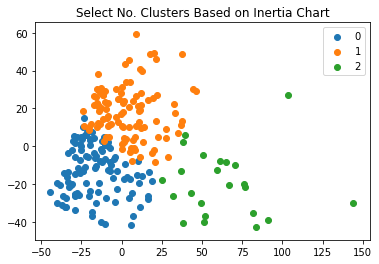

In [60]:
#filter rows of original data
num_clusters = 3;

kmeans_model_no_wf = KMeans(n_clusters=num_clusters, random_state=0)
pca_model_no_wf = PCA(num_clusters)
    
kmeans_no_wf = kmeans_model_no_wf.fit_predict(clean_hcm_scores[non_workforce_themes])
pca_df_no_wf = pca_model_no_wf.fit_transform(clean_hcm_scores[non_workforce_themes])

cluster_data = []

#Plotting the results
for i in range(0, num_clusters):
    cluster_data.append(pca_df_no_wf[kmeans_no_wf == i])
    plt.scatter(cluster_data[i][:,0], cluster_data[i][:,1] , label = i)
    
plt.title('Select No. Clusters Based on Inertia Chart')
plt.legend()
plt.show()

In [61]:
clean_hcm_scores["Cluster_No_WF"] = kmeans_no_wf
clean_hcm_scores["Cluster"] = kmeans


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [62]:
clean_hcm_scores[score_hcm_themes + ['Cluster_No_WF']].groupby(['Cluster_No_WF']).mean().T

Cluster_No_WF                                0          1          2
women_exec_mgmt_pct_recent            9.121296  25.348962  20.230435
women_workforce_pct_recent           21.203704  50.070755  46.295652
emp_turnover_annual_pct_recent        9.111111  12.518868  12.000000
prof_dev_train_hours_per_emp_recent  22.691019  25.649340  95.551304
women_senior_mgmt_pct_recent         13.371296  31.395283  29.665217
score                                65.654028  68.320660  66.617391

In [63]:
clean_hcm_scores[score_hcm_themes + ['Cluster']].groupby(['Cluster']).mean().T

Cluster                                      0           1          2  \
women_exec_mgmt_pct_recent            6.849254   23.033333  11.555556   
women_workforce_pct_recent           17.562687   45.994444  35.493651   
emp_turnover_annual_pct_recent        9.776119   12.222222   8.301587   
prof_dev_train_hours_per_emp_recent  20.613284  103.792778  26.686825   
women_senior_mgmt_pct_recent         10.283582   29.444444  23.760317   
score                                51.053284   67.566111  96.370000   

Cluster                                      3          4          5  
women_exec_mgmt_pct_recent           14.377500  34.359259  41.946154  
women_workforce_pct_recent           57.016667  43.929630  45.496154  
emp_turnover_annual_pct_recent       12.027778  15.592593  12.884615  
prof_dev_train_hours_per_emp_recent  38.863611  15.166296  24.151154  
women_senior_mgmt_pct_recent         27.133333  35.033333  31.373077  
score                                52.551528  28.246667  96.240000

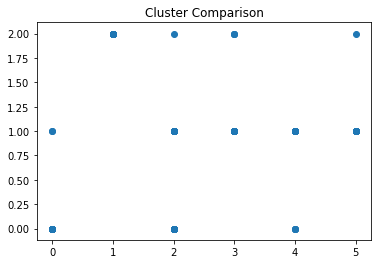

In [64]:
fig = plt.figure()
plt.scatter(clean_hcm_scores["Cluster"], clean_hcm_scores["Cluster_No_WF"])
    
plt.title('Cluster Comparison')
plt.show()

In [65]:
print("Clustering with Workforce Sophistication Score:\n")

print("Percent of Variance Explained:")
for var in range(1, len(pca_model.explained_variance_ratio_)+1):
    print("PCA Dimension "+str(var)+": ", str(round(pca_model.explained_variance_ratio_[var-1]*100,2))+"%")
    
print("\nTotal % of Variance Explained:", str(round(sum(pca_model.explained_variance_ratio_)*100,2))+"%")

Clustering with Workforce Sophistication Score:

Percent of Variance Explained:
PCA Dimension 1:  33.14%
PCA Dimension 2:  30.12%
PCA Dimension 3:  17.96%
PCA Dimension 4:  10.02%
PCA Dimension 5:  5.66%
PCA Dimension 6:  3.1%

Total % of Variance Explained: 100.0%


In [66]:
for j in range(0, num_clusters):
    print(str(j)+"_Component Loadings:")
    for i in range(0, len(score_hcm_themes)):
        print(score_hcm_themes[i]+": ", round(pca_model.components_[j][i], 4))
    print(" ")

0_Component Loadings:
women_exec_mgmt_pct_recent:  0.1433
women_workforce_pct_recent:  0.1957
emp_turnover_annual_pct_recent:  -0.0363
prof_dev_train_hours_per_emp_recent:  0.5078
women_senior_mgmt_pct_recent:  0.1201
score:  0.817
 
1_Component Loadings:
women_exec_mgmt_pct_recent:  0.1901
women_workforce_pct_recent:  0.2728
emp_turnover_annual_pct_recent:  0.0389
prof_dev_train_hours_per_emp_recent:  0.7249
women_senior_mgmt_pct_recent:  0.1811
score:  -0.5742
 
2_Component Loadings:
women_exec_mgmt_pct_recent:  0.4883
women_workforce_pct_recent:  0.5441
emp_turnover_annual_pct_recent:  0.1166
prof_dev_train_hours_per_emp_recent:  -0.4596
women_senior_mgmt_pct_recent:  0.4907
score:  0.0027
 


In [67]:
print("Clustering with NO Workforce Sophistication Score:\n")

print("Percent of Variance Explained:")
for var in range(1, len(pca_model_no_wf.explained_variance_ratio_)+1):
    print("PCA Dimension "+str(var)+": ", str(round(pca_model_no_wf.explained_variance_ratio_[var-1]*100,2))+"%")
    
print("\nTotal % of Variance Explained:", str(round(sum(pca_model_no_wf.explained_variance_ratio_)*100,2))+"%")

Clustering with NO Workforce Sophistication Score:

Percent of Variance Explained:
PCA Dimension 1:  45.81%
PCA Dimension 2:  26.43%
PCA Dimension 3:  14.75%

Total % of Variance Explained: 87.0%


In [68]:
for j in range(0, num_clusters):
    print(str(j)+"_Component Loadings:")
    for i in range(0, len(non_workforce_themes)):
        print(score_hcm_themes[i]+": ", round(pca_model_no_wf.components_[j][i], 4))
    print(" ")

0_Component Loadings:
women_exec_mgmt_pct_recent:  0.2384
women_workforce_pct_recent:  0.3358
emp_turnover_annual_pct_recent:  0.0083
prof_dev_train_hours_per_emp_recent:  0.8851
women_senior_mgmt_pct_recent:  0.2168
 
1_Component Loadings:
women_exec_mgmt_pct_recent:  0.4883
women_workforce_pct_recent:  0.5442
emp_turnover_annual_pct_recent:  0.1169
prof_dev_train_hours_per_emp_recent:  -0.4593
women_senior_mgmt_pct_recent:  0.4908
 
2_Component Loadings:
women_exec_mgmt_pct_recent:  0.794
women_workforce_pct_recent:  -0.5846
emp_turnover_annual_pct_recent:  -0.1433
prof_dev_train_hours_per_emp_recent:  0.0289
women_senior_mgmt_pct_recent:  -0.0804
 


In [69]:
comb_score = clean_hcm_scores.merge(ratings_data, how='left', on=["issuer_name", "file_date", "issuer_cusip", "issuer_sedol", "issuer_isin"])

In [70]:
comb_score.describe()

workforce_part_time_over_20pct_nm  women_exec_mgmt_pct_recent  \
count                         237.000000                  237.000000   
mean                           -0.059072                   17.457342   
std                             0.236258                   18.066189   
min                            -1.000000                    0.000000   
25%                             0.000000                    0.000000   
50%                             0.000000                   14.600000   
75%                             0.000000                   28.600000   
max                             0.000000                   80.000000   

       women_workforce_pct_recent  emp_turnover_annual_pct_recent  \
count                  237.000000                      237.000000   
mean                    36.549789                       10.915612   
std                     18.636729                        9.481541   
min                      1.700000                        0.000000   
25%                     21.500000                        5.000000   
50%                     36.100000                        9.000000   
75%                     52.000000                       14.000000   
max                     78.500000                       70.000000   

       prof_dev_train_hours_per_emp_recent  women_senior_mgmt_pct_recent  \
count                           237.000000                    237.000000   
mean                             31.084979                     23.013924   
std                              26.832484                     15.846943   
min                               1.210000                      0.000000   
25%                              13.000000                     11.100000   
50%                              23.350000                     23.100000   
75%                              40.000000                     33.300000   
max                             173.000000                     66.900000   

       human_capital_dev_med_risk_bus_pct  \
count                          237.000000   
mean                            49.967046   
std                             44.978101   
min                              0.000000   
25%                              0.000000   
50%                             51.110000   
75%                            100.000000   
max                            100.000000   

       human_capital_dev_high_risk_bus_pct         low         med  \
count                           237.000000  237.000000  237.000000   
mean                             41.956667    8.076287   49.967046   
std                              45.000002   24.979332   44.978101   
min                               0.000000   -0.010000    0.000000   
25%                               0.000000    0.000000    0.000000   
50%                              17.210000    0.000000   51.110000   
75%                              99.990000    0.010000  100.000000   
max                             100.000000  100.000000  100.000000   

             high       score  Cluster_No_WF     Cluster  \
count  237.000000  237.000000     237.000000  237.000000   
mean    41.956667   66.940190       0.641350    2.067511   
std     45.000002   28.613392       0.652618    1.676002   
min      0.000000    0.000000       0.000000    0.000000   
25%      0.000000   50.000000       0.000000    0.000000   
50%     17.210000   58.605000       1.000000    2.000000   
75%     99.990000   99.990000       1.000000    3.000000   
max    100.000000  100.000000       2.000000    5.000000   

       human_capital_theme_weight  human_capital_theme_score  \
count                  225.000000                 225.000000   
mean                    20.102222                   5.235111   
std                      8.419431                   2.043099   
min                      0.000000                   0.500000   
25%                     15.000000                   3.800000   
50%                     20.000000                   5.200000   
75%                     2

In [71]:
comb_score.groupby(['Cluster']).mean().T

Cluster                                      0           1          2  \
workforce_part_time_over_20pct_nm    -0.059701    0.000000  -0.031746   
women_exec_mgmt_pct_recent            6.849254   23.033333  11.555556   
women_workforce_pct_recent           17.562687   45.994444  35.493651   
emp_turnover_annual_pct_recent        9.776119   12.222222   8.301587   
prof_dev_train_hours_per_emp_recent  20.613284  103.792778  26.686825   
women_senior_mgmt_pct_recent         10.283582   29.444444  23.760317   
human_capital_dev_med_risk_bus_pct   90.021791   31.810000   6.345079   
human_capital_dev_high_risk_bus_pct   6.042388   51.661111  93.197460   
low                                   3.935821   16.528889   0.457460   
med                                  90.021791   31.810000   6.345079   
high                                  6.042388   51.661111  93.197460   
score                                51.053284   67.566111  96.370000   
Cluster_No_WF                         0.029851    2.000000   0.396825   
human_capital_theme_weight           22.301587   21.812500  19.885246   
human_capital_theme_score             5.411111    4.543750   5.101639   
human_capital_dev_weight              2.380952   12.500000  11.786885   
human_capital_dev_score               6.003175    5.631250   4.885246   
human_capital_dev_exp_score           5.712698    6.793750   8.080328   
human_capital_dev_mgmt_score          4.796825    5.425000   5.963934   

Cluster                                      3          4          5  
workforce_part_time_over_20pct_nm    -0.111111  -0.148148   0.000000  
women_exec_mgmt_pct_recent           14.377500  34.359259  41.946154  
women_workforce_pct_recent           57.016667  43.929630  45.496154  
emp_turnover_annual_pct_recent       12.027778  15.592593  12.884615  
prof_dev_train_hours_per_emp_recent  38.863611  15.166296  24.151154  
women_senior_mgmt_pct_recent         27.133333  35.033333  31.373077  
human_capital_dev_med_risk_bus_pct   86.797500  56.229630   7.519231  
human_capital_dev_high_risk_bus_pct   9.152778   0.131852  92.480385  
low                                   4.049722  43.638519   0.000385  
med                                  86.797500  56.229630   7.519231  
high                                  9.152778   0.131852  92.480385  
score                                52.551528  28.246667  96.240000  
Cluster_No_WF                         1.083333   0.851852   1.038462  
human_capital_theme_weight           16.138889  18.083333  21.640000  
human_capital_theme_score             5.997222   5.320833   4.380000  
human_capital_dev_weight             12.555556   3.875000  19.800000  
human_capital_dev_score               6.194444   7.337500   4.436000  
human_capital_dev_exp_score           6.638889   4.450000   8.324000  
human_capital_dev_mgmt_score          5.838889   4.983333   5.760000

In [72]:
comb_score.groupby(['Cluster_No_WF']).mean().T

Cluster_No_WF                                0          1          2
workforce_part_time_over_20pct_nm    -0.064815  -0.066038   0.000000
women_exec_mgmt_pct_recent            9.121296  25.348962  20.230435
women_workforce_pct_recent           21.203704  50.070755  46.295652
emp_turnover_annual_pct_recent        9.111111  12.518868  12.000000
prof_dev_train_hours_per_emp_recent  22.691019  25.649340  95.551304
women_senior_mgmt_pct_recent         13.371296  31.395283  29.665217
human_capital_dev_med_risk_bus_pct   58.365278  44.923962  33.773913
human_capital_dev_high_risk_bus_pct  36.471389  45.858679  49.730435
low                                   5.163333   9.217358  16.495652
med                                  58.365278  44.923962  33.773913
high                                 36.471389  45.858679  49.730435
score                                65.654028  68.320660  66.617391
Cluster                               0.870370   3.415094   1.478261
human_capital_theme_weight           21.346535  18.291262  23.000000
human_capital_theme_score             5.254455   5.327184   4.690476
human_capital_dev_weight              5.920792  12.291262  11.666667
human_capital_dev_score               5.642574   5.711650   5.623810
human_capital_dev_exp_score           6.523762   6.958252   6.657143
human_capital_dev_mgmt_score          5.216832   5.716505   5.280952

In [73]:
scores = ["human_capital_dev_mgmt_score", "human_capital_dev_exp_score",
          "human_capital_dev_score", "human_capital_theme_score"]

In [74]:
num_cols = int(len(scores) ** (1/2))
num_rows = len(scores) // num_cols 

if num_clusters % num_cols != 0:
    num_rows += 1

Position = range(1,len(scores) + 1)

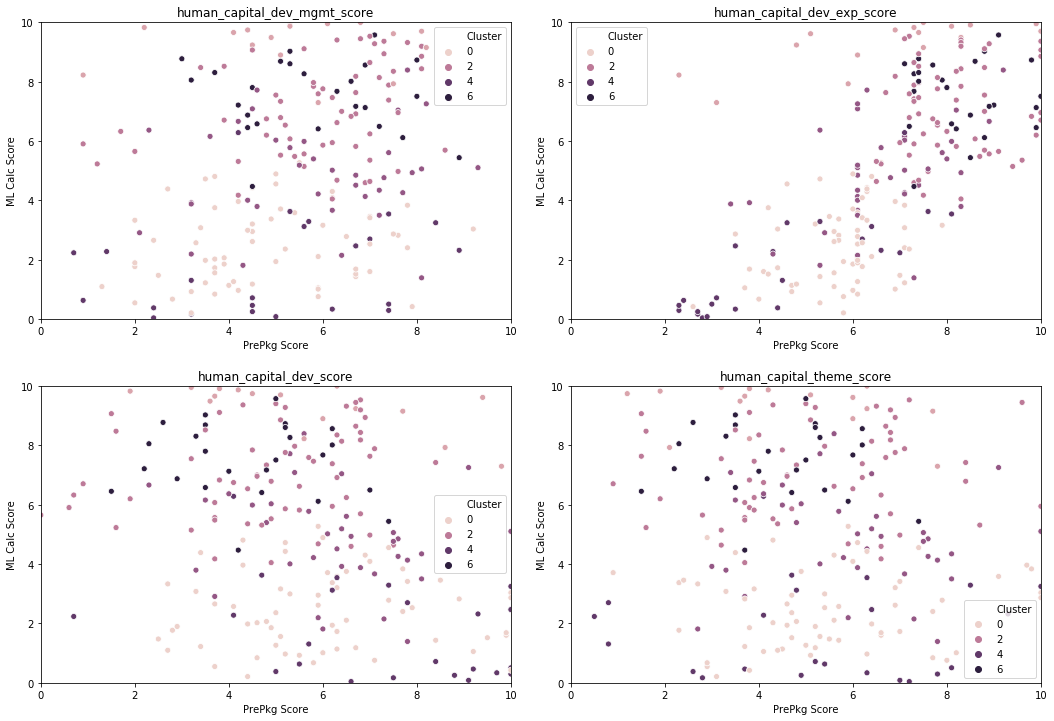

In [75]:
comb_score["Calced Score"] = (.4 * comb_score["score"] ) + (.4 * comb_score["prof_dev_train_hours_per_emp_recent"] ) + (.2 * (comb_score["women_exec_mgmt_pct_recent"] + comb_score["women_workforce_pct_recent"] + comb_score["women_senior_mgmt_pct_recent"] ) / 3 )
comb_score["Calc_Score_Transformed"] = comb_score["Calced Score"].rank(pct=True)*10

fig = plt.figure(1, figsize=(15,15))
for k in range(1, len(scores)+1):
    ax = fig.add_subplot(num_rows,num_cols,Position[k-1])
    
    sns.scatterplot(x=scores[k-1], y='Calc_Score_Transformed', data=comb_score, hue='Cluster', ax=ax)
    ax.set_xlabel('PrePkg Score')
    ax.set_xlim(0, 10)
    ax.set_ylabel('ML Calc Score')
    ax.set_ylim(0, 10)
    ax.set_title(scores[k-1])
    ax.legend()

fig.tight_layout(pad=2)
plt.show()

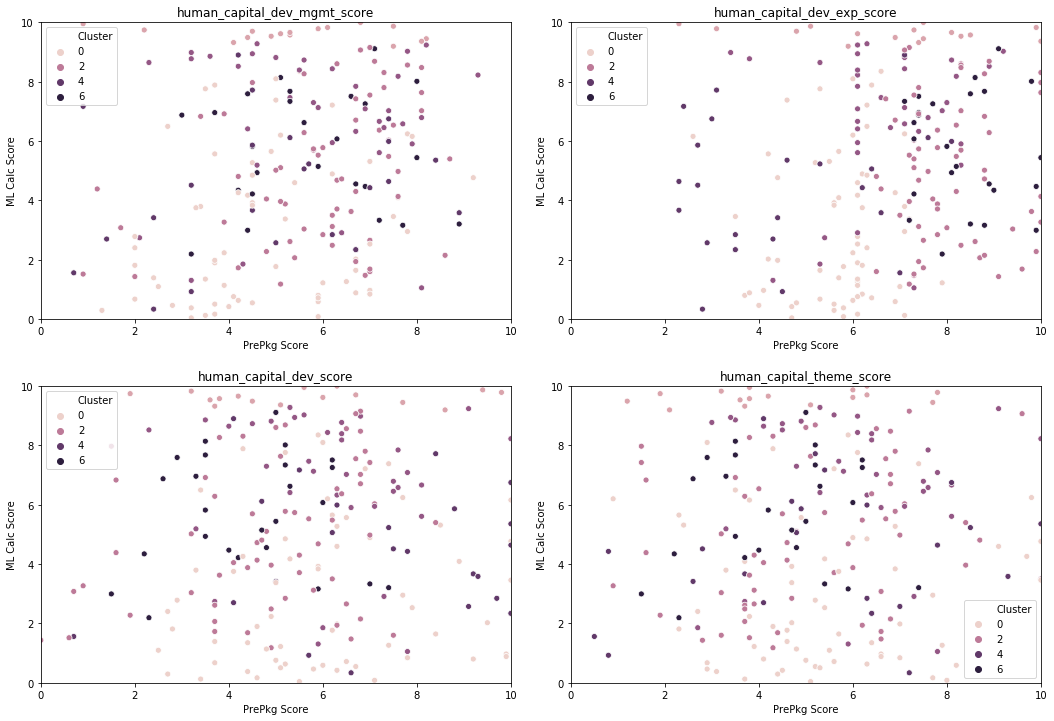

In [76]:
comb_score["Calced Score_NO_WF"] = (.5 * comb_score["prof_dev_train_hours_per_emp_recent"] ) - (.2 * comb_score["emp_turnover_annual_pct_recent"] ) + (.3 * (comb_score["women_exec_mgmt_pct_recent"] + comb_score["women_workforce_pct_recent"] + comb_score["women_senior_mgmt_pct_recent"] ) / 3 )
comb_score["Calc_Score_NO_WF_Transformed"] = comb_score["Calced Score_NO_WF"].rank(pct=True)*10
scores = ["human_capital_dev_mgmt_score", "human_capital_dev_exp_score",
          "human_capital_dev_score", "human_capital_theme_score"]

fig = plt.figure(1, figsize=(15,15))
for k in range(1, len(scores)+1):
    ax = fig.add_subplot(num_rows,num_cols,Position[k-1])
    
    sns.scatterplot(x=scores[k-1], y='Calc_Score_NO_WF_Transformed', data=comb_score, hue='Cluster', ax=ax)
    ax.set_xlabel('PrePkg Score')
    ax.set_xlim(0, 10)
    ax.set_ylabel('ML Calc Score')
    ax.set_ylim(0, 10)
    ax.set_title(scores[k-1])
    ax.legend()

fig.tight_layout(pad=2)
plt.show()

In [77]:
comb_score["Score Bucket"] = np.floor(comb_score["human_capital_theme_score"] / 5)

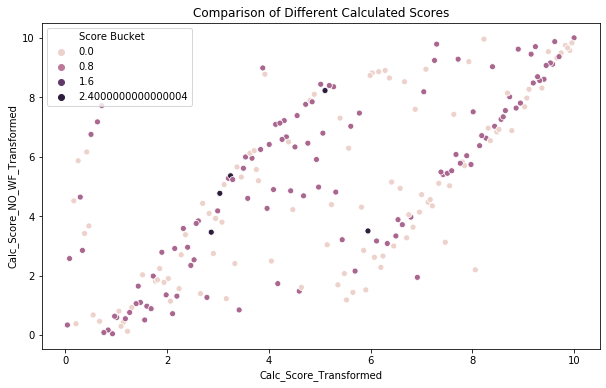

In [78]:
fig = plt.figure(1, figsize=(10,6))
ax = fig.add_subplot(1,1,1)
sns.scatterplot(x='Calc_Score_Transformed', y='Calc_Score_NO_WF_Transformed', hue="Score Bucket", data=comb_score, ax=ax)
plt.title('Comparison of Different Calculated Scores')

plt.show()

invalid value encountered in greater_equal
invalid value encountered in less_equal


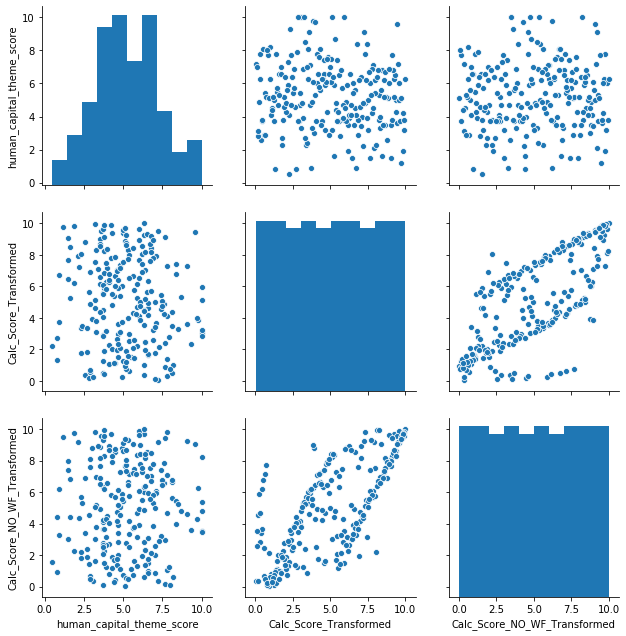

In [79]:
sns.pairplot(comb_score[["human_capital_theme_score", "Calc_Score_Transformed", "Calc_Score_NO_WF_Transformed"]], height = 3)
plt.show()

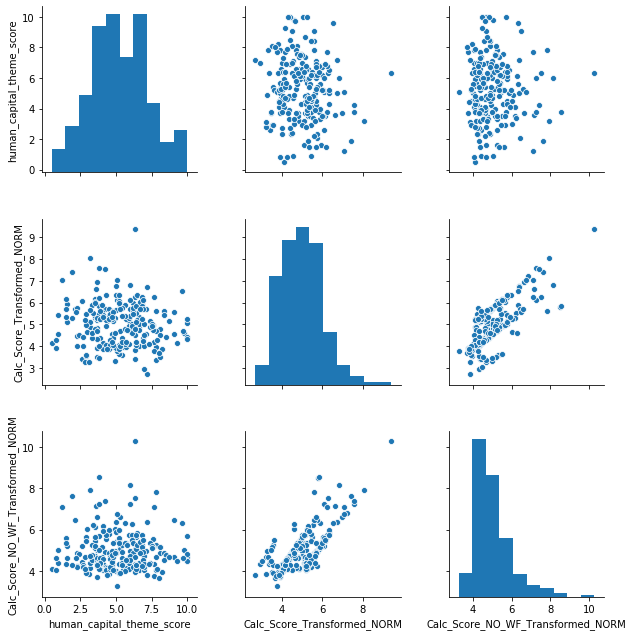

In [80]:
comb_score["Calc_Score_Transformed_NORM"] = (comb_score["Calced Score"] - np.mean(comb_score["Calced Score"]) ) / np.std(comb_score["Calced Score"]) + 5
comb_score["Calc_Score_NO_WF_Transformed_NORM"] = (comb_score["Calced Score_NO_WF"] - np.mean(comb_score["Calced Score_NO_WF"]) ) / np.std(comb_score["Calced Score_NO_WF"]) + 5
                                                   
sns.pairplot(comb_score[["human_capital_theme_score", "Calc_Score_Transformed_NORM", "Calc_Score_NO_WF_Transformed_NORM"]], height=3)
plt.show()

invalid value encountered in log


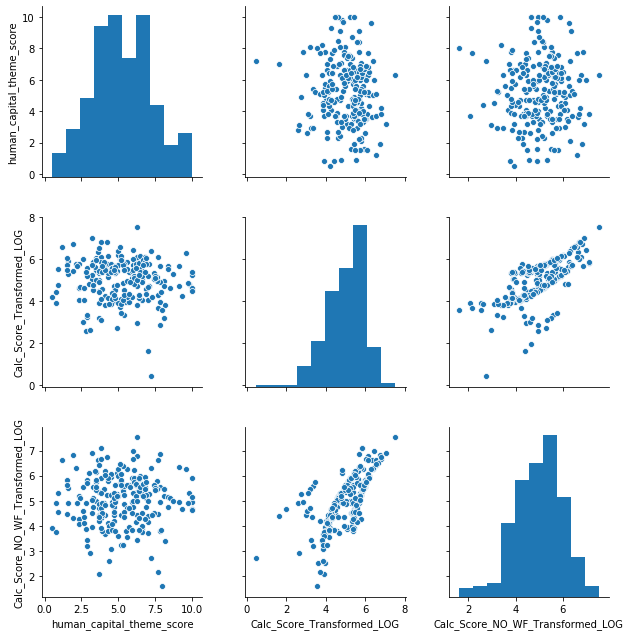

In [81]:
comb_score["Calc_Score_Transformed_LOG"] = (np.log(comb_score["Calced Score"]) - np.mean(np.log(comb_score["Calced Score"])) ) / np.std(np.log(comb_score["Calced Score"])) + 5
comb_score["Calc_Score_NO_WF_Transformed_LOG"] = (np.log(comb_score["Calced Score_NO_WF"]) - np.mean(np.log(comb_score["Calced Score_NO_WF"])) ) / np.std(np.log(comb_score["Calced Score_NO_WF"])) + 5
                                                   
sns.pairplot(comb_score[["human_capital_theme_score", "Calc_Score_Transformed_LOG", "Calc_Score_NO_WF_Transformed_LOG"]], height=3)
plt.show()


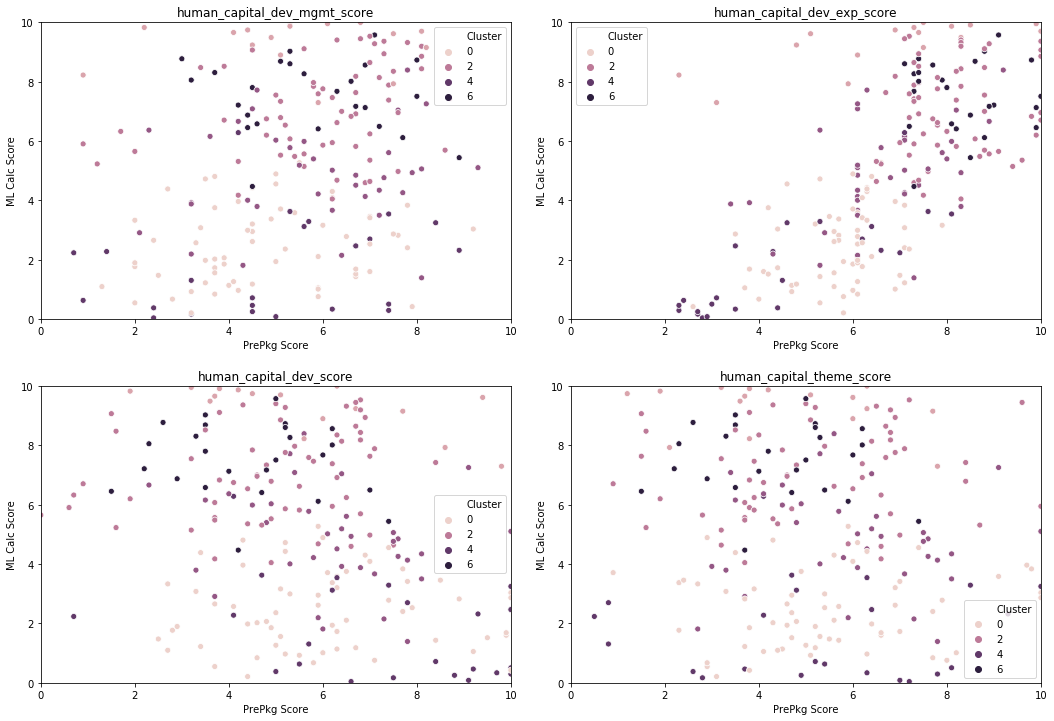

In [82]:
fig = plt.figure(1, figsize=(15,15))
for k in range(1, len(scores)+1):
    ax = fig.add_subplot(num_rows,num_cols,Position[k-1])
    
    sns.scatterplot(x=scores[k-1], y='Calc_Score_Transformed', data=comb_score, hue='Cluster', ax=ax)
    ax.set_xlabel('PrePkg Score')
    ax.set_xlim(0, 10)
    ax.set_ylabel('ML Calc Score')
    ax.set_ylim(0, 10)
    ax.set_title(scores[k-1])
    ax.legend()

fig.tight_layout(pad=2)
plt.show()

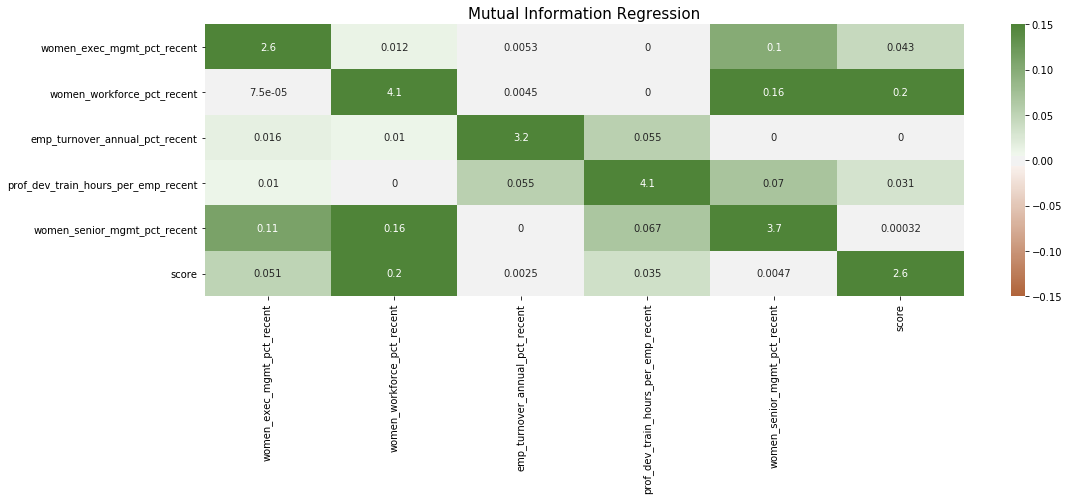

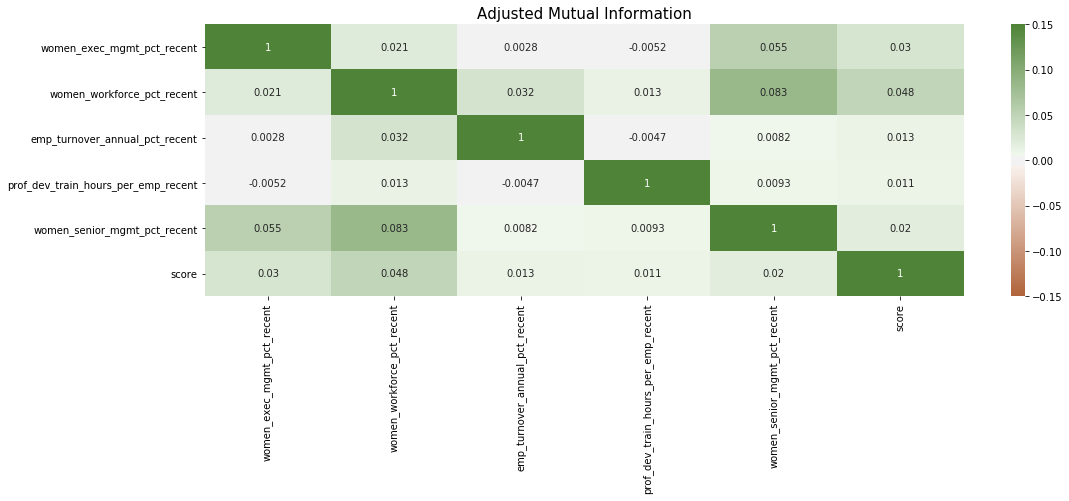

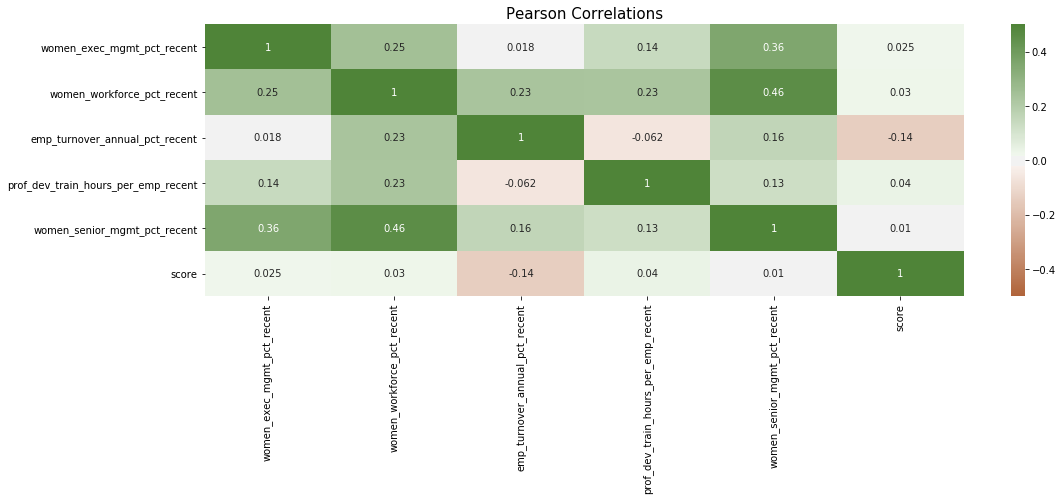

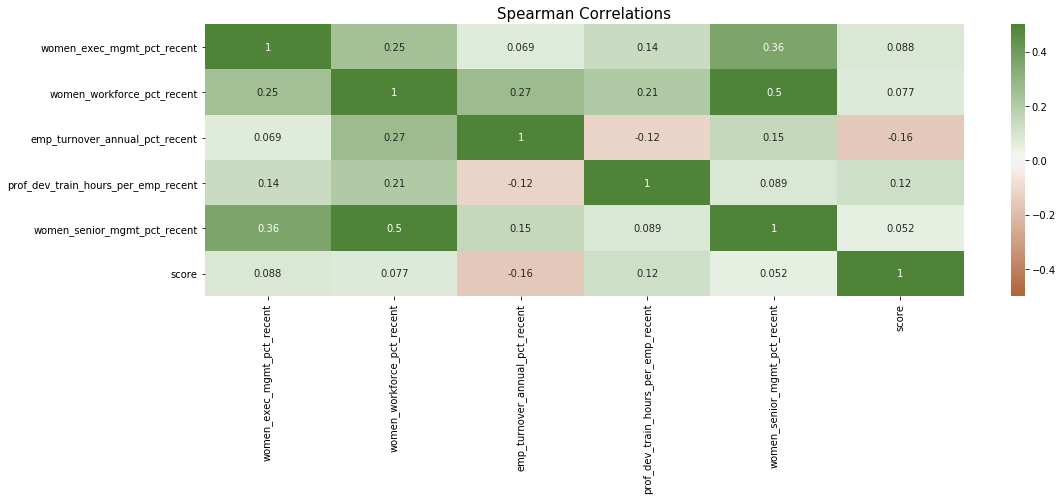

In [83]:
perms = list(itertools.permutations(score_hcm_themes, 2))
matrix_val = pd.DataFrame(columns = score_hcm_themes)

mi_reg = MIRegression()
pear_corr = PearsonCorrelation()
spear_corr = SpearmanCorrelation()
adjMI = AdjMI()

matrix_template = comb_score[score_hcm_themes].corr()
rows = matrix_template.index
cols = matrix_template.columns

mi_reg_mat = matrix_template.copy()
pear_mat = matrix_template.copy()
spear_mat = matrix_template.copy()
adjMi_mat = matrix_template.copy()

warnings.filterwarnings("ignore")
for r in rows:
    for c in cols:
        mi_reg_mat.at[r, c ] = mi_reg.predict(comb_score[r], comb_score[c])
        pear_mat.at[r, c ] = pear_corr.predict(comb_score[r], comb_score[c])
        spear_mat.at[r, c ] = spear_corr.predict(comb_score[r], comb_score[c])
        adjMi_mat.at[r, c ] = adjMI.predict(comb_score[r], comb_score[c])
        
colors = sns.diverging_palette(30, 120, as_cmap=True)
plt.figure(figsize=(17, 5))
sns.heatmap(mi_reg_mat, cmap=colors, vmax = .15, vmin =-.15, annot=True)
plt.title("Mutual Information Regression", {"fontsize":15})
plt.show()

colors = sns.diverging_palette(30, 120, as_cmap=True)
plt.figure(figsize=(17, 5))
sns.heatmap(adjMi_mat, cmap=colors, vmax = .15, vmin =-.15, annot=True)
plt.title("Adjusted Mutual Information", {"fontsize":15})
plt.show()

colors = sns.diverging_palette(30, 120, as_cmap=True)
plt.figure(figsize=(17, 5))
sns.heatmap( pear_mat, cmap=colors, vmax = .5, vmin =-.5, annot=True)
plt.title("Pearson Correlations", {"fontsize":15})
plt.show()

colors = sns.diverging_palette(30, 120, as_cmap=True)
plt.figure(figsize=(17, 5))
sns.heatmap(spear_mat, cmap=colors, vmax = .5, vmin =-.5, annot=True)
plt.title("Spearman Correlations", {"fontsize":15})
plt.show()

In [84]:
hcm_data = hcm_data_raw.drop(hcm_data_raw[hcm_data_raw.women_senior_mgmt_pct_recent > 100].index)
hcm_data = hcm_data.drop(hcm_data[hcm_data.women_exec_mgmt_pct_recent > 100].index)
hcm_data = hcm_data.drop(hcm_data[hcm_data.women_workforce_pct_recent > 100].index)
hcm_data = hcm_data.drop(hcm_data[hcm_data.human_capital_dev_high_risk_bus_pct > 100].index)
hcm_data = hcm_data.drop_duplicates(subset=['issuer_name'])

In [85]:
hcm_data["low"] = 100 - (hcm_data["human_capital_dev_med_risk_bus_pct"] + hcm_data["human_capital_dev_high_risk_bus_pct"])
hcm_data["med"] = hcm_data["human_capital_dev_med_risk_bus_pct"]
hcm_data["high"] = hcm_data["human_capital_dev_high_risk_bus_pct"]
hcm_data["score"] = (0 * hcm_data["low"]) + (.5  * hcm_data["med"]) +(1 * hcm_data["high"])

In [86]:
hcm_data["ML Score"] = (.4 * hcm_data["score"] ) + (.4 * hcm_data["prof_dev_train_hours_per_emp_recent"] ) + (.2 * (hcm_data["women_exec_mgmt_pct_recent"] + hcm_data["women_workforce_pct_recent"] + hcm_data["women_senior_mgmt_pct_recent"] ) / 3 )

In [87]:
scores = hcm_data[['file_date', 'issuer_name', 'issuer_cusip', 'issuer_sedol', 'issuer_isin', 'ML Score']]

In [88]:
scores = scores.dropna()

In [89]:
scores["ML Rating PctTile"] = scores["ML Score"].rank(pct=True)*10

In [90]:
stdev = np.std(scores["ML Score"])
mean = np.mean(scores["ML Score"])

In [91]:
scores["Z Score"] = (( scores["ML Score"] - mean ) / stdev )
scores["Z Score Centered"] = scores["Z Score"] + 5
scores["Z Score Centered"][scores["Z Score Centered"] > 10] = 10
scores["Z Score Centered"][scores["Z Score Centered"] < 0] = 0

In [92]:
trim_scores = scores.drop(scores[scores["Z Score"] < -3].index)
trim_scores = trim_scores.drop(trim_scores[trim_scores["Z Score"] > 3].index)

In [93]:
trim_stdev = np.std(trim_scores["ML Score"])
trim_mean = np.mean(trim_scores["ML Score"])

In [94]:
scores["Z Score Norm"] = ( ( scores["ML Score"] - trim_mean ) / (trim_stdev * 0.5) ) + 5


In [95]:
scores["Z Score Norm"][scores["Z Score Norm"] > 10] = 10
scores["Z Score Norm"][scores["Z Score Norm"] < 0] = 0

In [96]:
full_scores = scores.merge(ratings_data, how='left', on=["issuer_name"])

In [97]:
full_scores.describe()

ML Score  ML Rating PctTile       Z Score  Z Score Centered  \
count  327.000000         327.000000  3.270000e+02        327.000000   
mean    43.175941           5.015291  3.228814e-16          4.996594   
std     17.761754           2.891162  1.001533e+00          0.982389   
min      1.361333           0.030581 -2.357802e+00          2.642198   
25%     30.121333           2.522936 -7.361106e-01          4.263889   
50%     41.909333           5.015291 -7.142024e-02          4.928580   
75%     54.615333           7.507645  6.450334e-01          5.645033   
max    151.600000          10.000000  6.113711e+00         10.000000   

       Z Score Norm  human_capital_theme_weight  human_capital_theme_score  \
count    327.000000                  301.000000                 301.000000   
mean       5.021055                   20.169435                   5.137209   
std        2.007588                    8.546024                   1.984879   
min        0.000000                    0.000000                   0.300000   
25%        3.459567                   15.000000                   3.800000   
50%        4.913046                   20.000000                   5.100000   
75%        6.479717                   25.000000                   6.400000   
max       10.000000                   56.000000                  10.000000   

       human_capital_dev_weight  human_capital_dev_score  \
count                301.000000               301.000000   
mean                   9.073090                 5.597342   
std                   10.368284                 2.061971   
min                    0.000000                 0.000000   
25%                    0.000000                 4.300000   
50%                    0.000000                 5.500000   
75%                   15.000000                 6.800000   
max                   35.000000                10.000000   

       human_capital_dev_exp_score  human_capital_dev_mgmt_score  
count                   301.000000                    301.000000  
mean                      6.634884                      5.265116  
std                       1.758222                      1.823096  
min                       2.300000                      0.700000  
25%                       5.700000                      4.100000  
50%                       6.600000                      5.300000  
75%                       7.800000                      6.700000  
max                      10.000000                      9.300000

In [98]:
full_scores = full_scores.dropna()

In [99]:
full_scores.describe()

ML Score  ML Rating PctTile     Z Score  Z Score Centered  \
count  301.000000         301.000000  301.000000        301.000000   
mean    43.574230           5.068325    0.022458          5.018758   
std     17.496269           2.839752    0.986563          0.965505   
min      6.073333           0.061162   -2.092106          2.907894   
25%     30.732000           2.629969   -0.701677          4.298323   
50%     41.977333           5.045872   -0.067586          4.932414   
75%     54.493333           7.492355    0.638154          5.638154   
max    151.600000          10.000000    6.113711         10.000000   

       Z Score Norm  human_capital_theme_weight  human_capital_theme_score  \
count    301.000000                  301.000000                 301.000000   
mean       5.065716                   20.169435                   5.137209   
std        1.956938                    8.546024                   1.984879   
min        0.494409                    0.000000                   0.300000   
25%        3.534863                   15.000000                   3.800000   
50%        4.921431                   20.000000                   5.100000   
75%        6.464674                   25.000000                   6.400000   
max       10.000000                   56.000000                  10.000000   

       human_capital_dev_weight  human_capital_dev_score  \
count                301.000000               301.000000   
mean                   9.073090                 5.597342   
std                   10.368284                 2.061971   
min                    0.000000                 0.000000   
25%                    0.000000                 4.300000   
50%                    0.000000                 5.500000   
75%                   15.000000                 6.800000   
max                   35.000000                10.000000   

       human_capital_dev_exp_score  human_capital_dev_mgmt_score  
count                   301.000000                    301.000000  
mean                      6.634884                      5.265116  
std                       1.758222                      1.823096  
min                       2.300000                      0.700000  
25%                       5.700000                      4.100000  
50%                       6.600000                      5.300000  
75%                       7.800000                      6.700000  
max                      10.000000                      9.300000

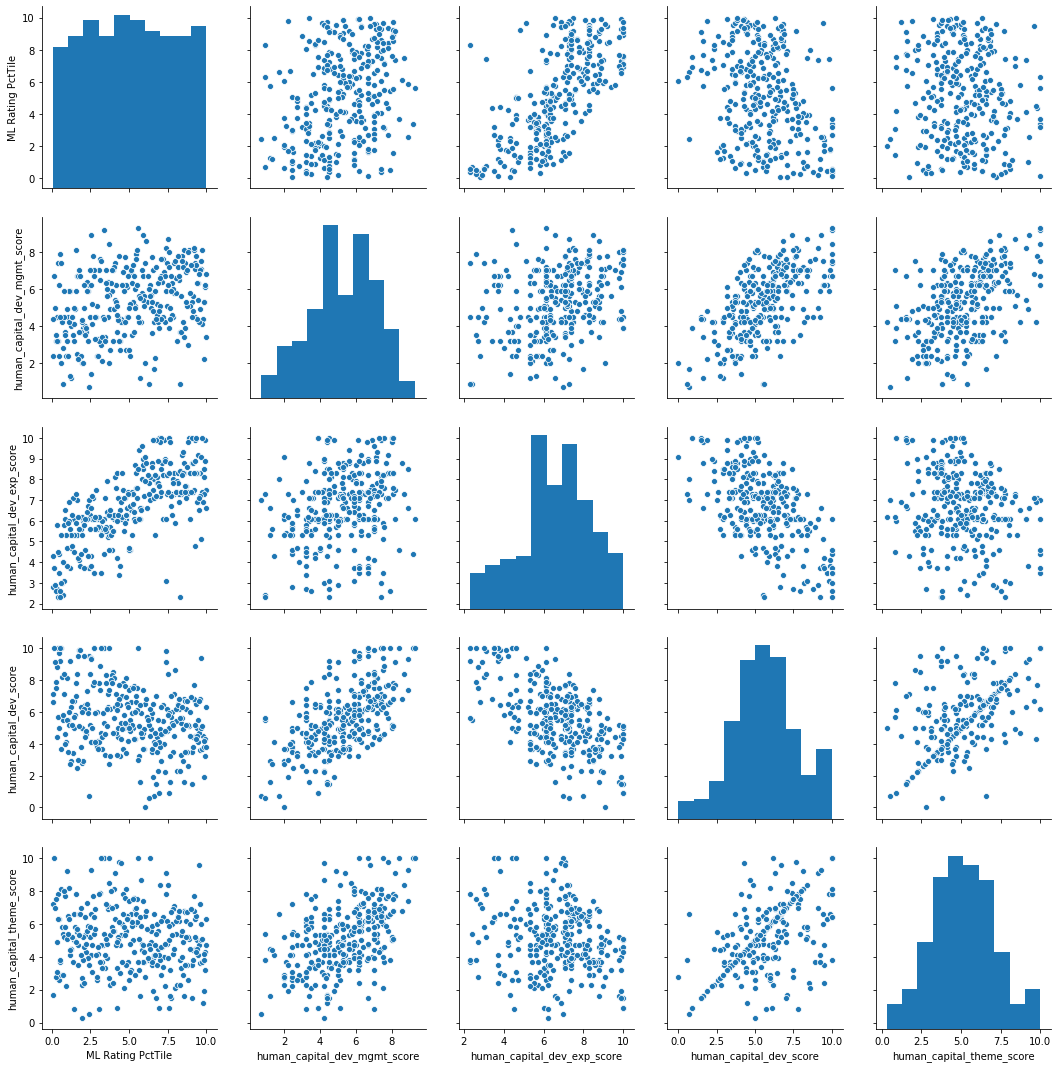

In [100]:
sns.pairplot(full_scores[["ML Rating PctTile", "human_capital_dev_mgmt_score", "human_capital_dev_exp_score", 
                          "human_capital_dev_score", "human_capital_theme_score"]], height=3)
plt.show()

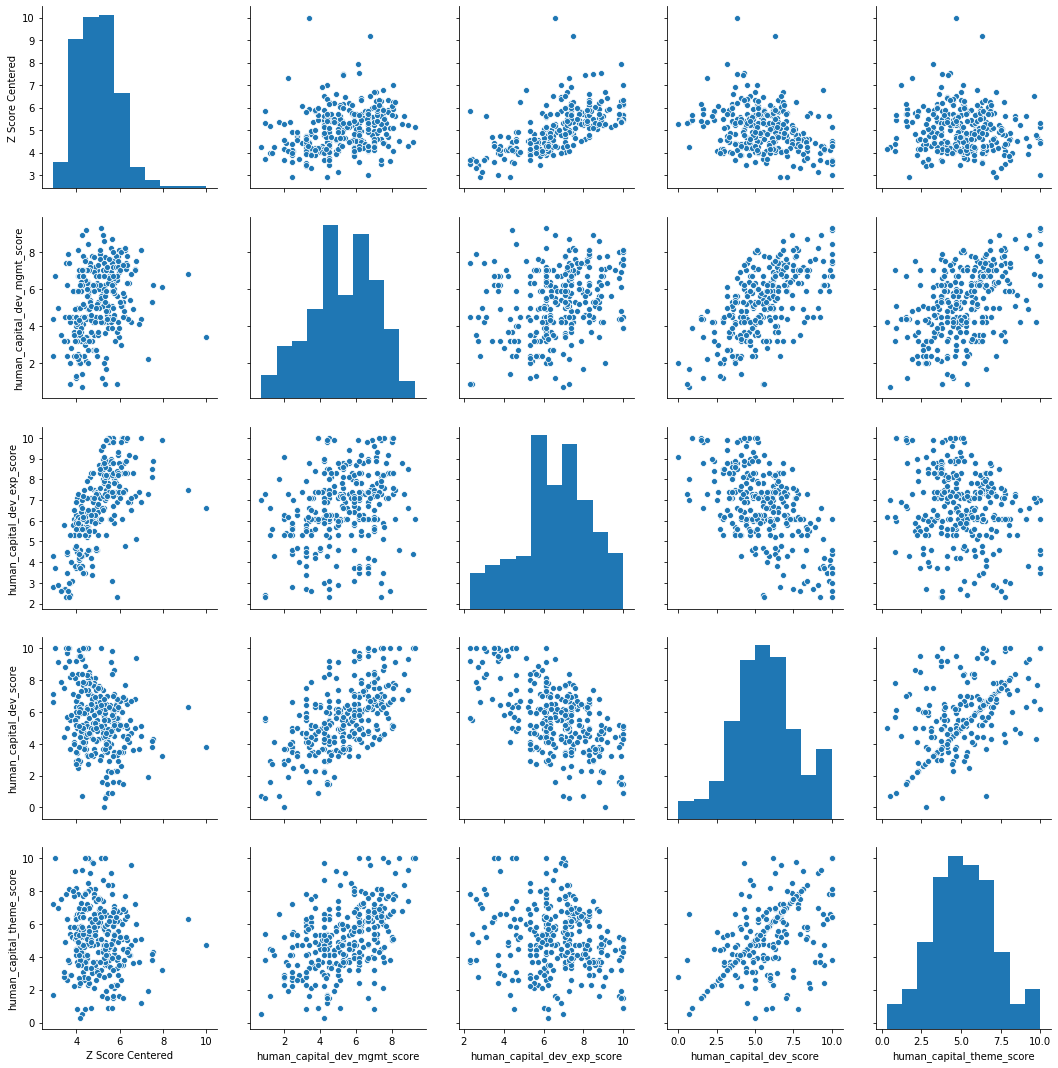

In [101]:
sns.pairplot(full_scores[["Z Score Centered", "human_capital_dev_mgmt_score", "human_capital_dev_exp_score", 
                          "human_capital_dev_score", "human_capital_theme_score"]], height=3)
plt.show()

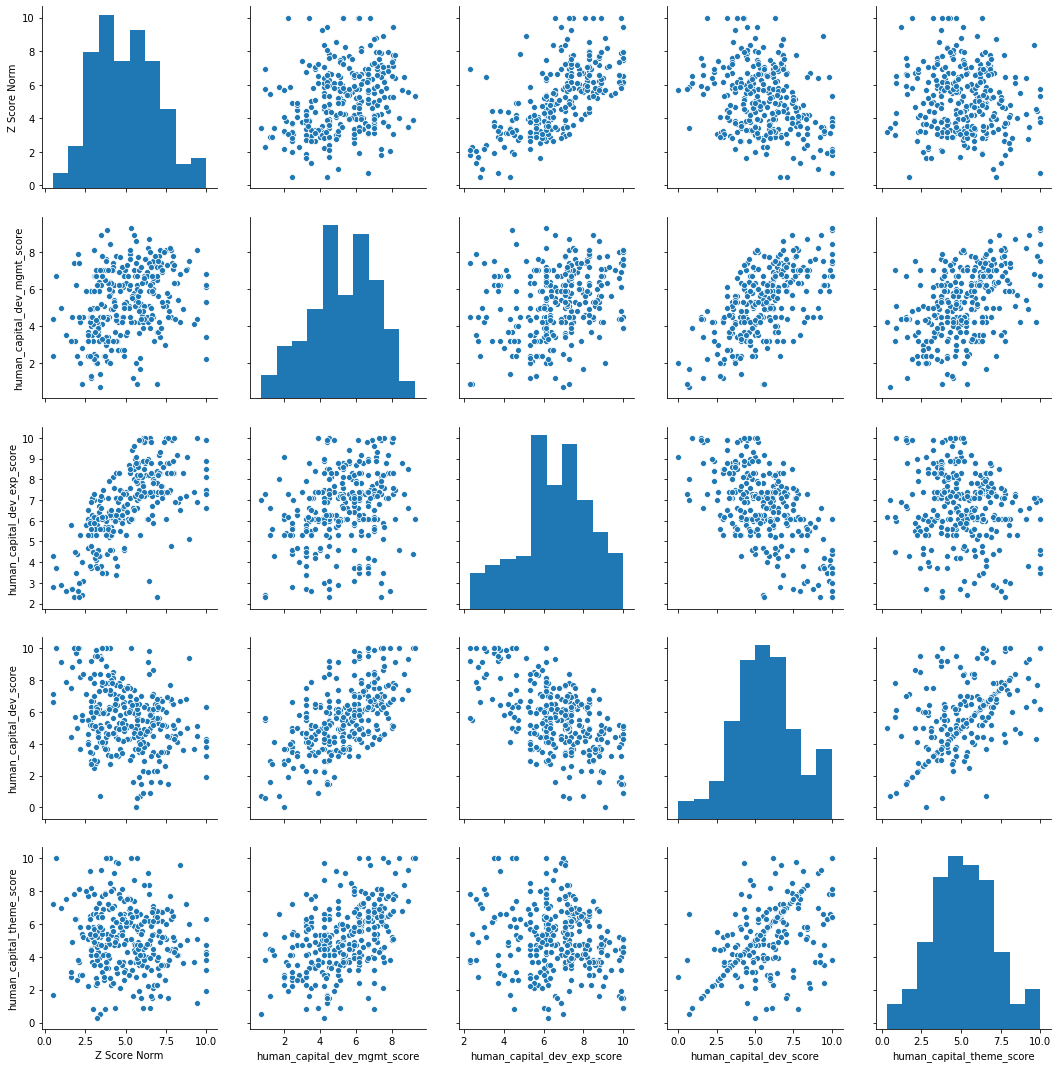

In [102]:
sns.pairplot(full_scores[["Z Score Norm", "human_capital_dev_mgmt_score", "human_capital_dev_exp_score", 
                          "human_capital_dev_score", "human_capital_theme_score"]], height=3)
plt.show()

## Interaction with Policy Data

In [103]:
print("Possible Values for Degree Program Policy:")
    
for i in set(hcm_policy_raw['prof_dev_degree_programs']):
    print ('"'+i+'"')

Possible Values for Degree Program Policy:
""
"Programs covering all employees (including part-time and contractors)"
"No evidence"
"Programs covering all permanent employees (excluding part-time and contractors)"
"General statements on training and development"


In [104]:
degree_dict = {}

degree_dict[""] = 0
degree_dict["Programs covering all employees (including part-time and contractors)"] = 1
degree_dict["No evidence"] = -1
degree_dict["General statements on training and development"] = 0
degree_dict["Programs covering all permanent employees (excluding part-time and contractors)"] = 1

print("Encoding of Possible Values for Degree Program Policy: \n")

for k in degree_dict.keys():
    print(k+": \t", degree_dict[k])

Encoding of Possible Values for Degree Program Policy: 

: 	 0
Programs covering all employees (including part-time and contractors): 	 1
No evidence: 	 -1
General statements on training and development: 	 0
Programs covering all permanent employees (excluding part-time and contractors): 	 1


In [105]:
print("Possible Values for Degree Program Policy:")
    
for i in set(hcm_policy_raw['prof_dev_train_leader_manag']):
    print ('"'+i+'"')

Possible Values for Degree Program Policy:
""
"General statements on leadership training with unknown scope or achieved results"
"Comprehensive succession planning  & development programs at multiple levels"
"No evidence"
"Programs focusing on internal upward mobility through training and development"
"Minimum practices expected based on domestic industry norms"


In [106]:
dev_dict = {}

dev_dict[""] = 0
dev_dict["General statements on leadership training with unknown scope or achieved results"] = 0
dev_dict["Comprehensive succession planning  & development programs at multiple levels"] = 1
dev_dict["No evidence"] = -1
dev_dict["Minimum practices expected based on domestic industry norms"] = 0
dev_dict["Programs focusing on internal upward mobility through training and development"] = 1

print("Encoding of Possible Values for Degree Program Policy: \n")

for k in dev_dict.keys():
    print(k+": \t", dev_dict[k])

Encoding of Possible Values for Degree Program Policy: 

: 	 0
General statements on leadership training with unknown scope or achieved results: 	 0
Comprehensive succession planning  & development programs at multiple levels: 	 1
No evidence: 	 -1
Minimum practices expected based on domestic industry norms: 	 0
Programs focusing on internal upward mobility through training and development: 	 1


In [107]:
hcm_policy = hcm_policy_raw.drop_duplicates(subset=['issuer_name'])

In [108]:
hcm_policy["Degree Program"] = hcm_policy['prof_dev_degree_programs'].map(degree_dict)
hcm_policy["Dev Program"] = hcm_policy['prof_dev_train_leader_manag'].map(dev_dict)
hcm_policy["Overall Policy"] = (hcm_policy["Dev Program"] + hcm_policy["Degree Program"] ) / 2.0

In [109]:
full_hcm = hcm_policy.merge(hcm_data, how='left', on=['file_date', 'issuer_name', 'issuer_cusip', 'issuer_sedol', 'issuer_isin'])

In [110]:

full_hcm["ML Score with Policy"] = (.4 * full_hcm["score"] * full_hcm["Overall Policy"] ) + (.4 * full_hcm["prof_dev_train_hours_per_emp_recent"] ) + (.2 * (full_hcm["women_exec_mgmt_pct_recent"] + full_hcm["women_workforce_pct_recent"] + full_hcm["women_senior_mgmt_pct_recent"] ) / 3 )
    
full_hcm["ML Score NO Policy"] = (.4 * full_hcm["score"] ) + (.4 * full_hcm["prof_dev_train_hours_per_emp_recent"] ) + (.2 * (full_hcm["women_exec_mgmt_pct_recent"] + full_hcm["women_workforce_pct_recent"] + full_hcm["women_senior_mgmt_pct_recent"] ) / 3 )

In [111]:
full_hcm = full_hcm.dropna()

In [112]:
final_scores = full_hcm.merge(ratings_data, how='left', on=['file_date', 'issuer_name', 'issuer_cusip', 'issuer_sedol', 'issuer_isin'])

In [113]:
final_scores.describe()

Degree Program  Dev Program  Overall Policy  \
count      237.000000   237.000000      237.000000   
mean         0.059072     0.645570        0.352321   
std          0.593656     0.553218        0.426014   
min         -1.000000    -1.000000       -1.000000   
25%          0.000000     0.000000        0.000000   
50%          0.000000     1.000000        0.500000   
75%          0.000000     1.000000        0.500000   
max          1.000000     1.000000        1.000000   

       workforce_part_time_over_20pct_nm  women_exec_mgmt_pct_recent  \
count                         237.000000                  237.000000   
mean                           -0.059072                   17.457342   
std                             0.236258                   18.066189   
min                            -1.000000                    0.000000   
25%                             0.000000                    0.000000   
50%                             0.000000                   14.600000   
75%                             0.000000                   28.600000   
max                             0.000000                   80.000000   

       women_workforce_pct_recent  emp_turnover_annual_pct_recent  \
count                  237.000000                      237.000000   
mean                    36.549789                       10.915612   
std                     18.636729                        9.481541   
min                      1.700000                        0.000000   
25%                     21.500000                        5.000000   
50%                     36.100000                        9.000000   
75%                     52.000000                       14.000000   
max                     78.500000                       70.000000   

       prof_dev_train_hours_per_emp_recent  women_senior_mgmt_pct_recent  \
count                           237.000000                    237.000000   
mean                             31.084979                     23.013924   
std                              26.832484                     15.846943   
min                               1.210000                      0.000000   
25%                              13.000000                     11.100000   
50%                              23.350000                     23.100000   
75%                              40.000000                     33.300000   
max                             173.000000                     66.900000   

       human_capital_dev_med_risk_bus_pct  ...       score    ML Score  \
count                          237.000000  ...  237.000000  237.000000   
mean                            49.967046  ...   66.940190   44.344805   
std                             44.978101  ...   28.613392   16.654415   
min                              0.000000  ...    0.000000    6.153333   
25%                              0.000000  ...   50.000000   30.822000   
50%                             51.110000  ...   58.605000   44.765333   
75%                            100.000000  ...   99.990000   55.020000   
max                            100.000000  ...  100.000000  117.206000   

       ML Score with Policy  ML Score NO Policy  human_capital_theme_weight  \
count            237.000000          237.000000                  225.000000   
mean              27.657826           44.344805                   20.102222   
std               18.026667           16.654415                    8.419431   
min              -10.286667            6.153333                    0.000000   
25%               15.680000           30.822000                   15.000000   
50%               26.671333           44.765333                   20.000000   
75%               38.246667           55.020000                   25.000000   
max               98.113000          117.206000                   56.000000   

       human_capital_theme_score  human_capital_dev_weight  \
count                 225.000000                225.000000   
mean                    5.235111                  9.373333   

In [114]:
stdev = np.std(final_scores["ML Score with Policy"])
mean = np.mean(final_scores["ML Score with Policy"])

final_scores["Z Score with Policy"] = (( final_scores["ML Score with Policy"] - mean ) / stdev )
final_scores["Z Score Centered with Policy"] = final_scores["Z Score with Policy"] + 5 
final_scores["Z Score Centered with Policy"][final_scores["Z Score Centered with Policy"] > 10] = 10
final_scores["Z Score Centered with Policy"][final_scores["Z Score Centered with Policy"] < 0] = 0

trim_final_scores = final_scores.drop(final_scores[final_scores["Z Score with Policy"] < -3].index)
trim_final_scores = trim_final_scores.drop(trim_final_scores[trim_final_scores["Z Score with Policy"] > 3].index)

trim_stdev = np.std(trim_final_scores["ML Score with Policy"])
trim_mean = np.mean(trim_final_scores["ML Score with Policy"])

final_scores["Z Score Norm with Policy"] = ( ( final_scores["ML Score with Policy"] - trim_mean ) / (trim_stdev * 0.5) ) + 5
final_scores["Z Score Norm with Policy"][final_scores["Z Score Norm with Policy"] > 10] = 10
final_scores["Z Score Norm with Policy"][final_scores["Z Score Norm with Policy"] < 0] = 0

In [115]:
stdev = np.std(final_scores["ML Score NO Policy"])
mean = np.mean(final_scores["ML Score NO Policy"])

final_scores["Z Score NO Policy"] = (( final_scores["ML Score NO Policy"] - mean ) / stdev )
final_scores["Z Score Centered NO Policy"] = final_scores["Z Score NO Policy"] + 5 
final_scores["Z Score Centered NO Policy"][final_scores["Z Score Centered NO Policy"] > 10] = 10
final_scores["Z Score Centered NO Policy"][final_scores["Z Score Centered NO Policy"] < 0] = 0

trim_final_scores = final_scores.drop(final_scores[final_scores["Z Score NO Policy"] < -3].index)
trim_final_scores = trim_final_scores.drop(trim_final_scores[trim_final_scores["Z Score NO Policy"] > 3].index)

trim_stdev = np.std(trim_final_scores["ML Score NO Policy"])
trim_mean = np.mean(trim_final_scores["ML Score NO Policy"])

final_scores["Z Score Norm NO Policy"] = ( ( final_scores["ML Score NO Policy"] - trim_mean ) / (trim_stdev * 0.5) ) + 5
final_scores["Z Score Norm NO Policy"][final_scores["Z Score Norm NO Policy"] > 10] = 10
final_scores["Z Score Norm NO Policy"][final_scores["Z Score Norm NO Policy"] < 0] = 0

In [116]:
final_scores = final_scores.merge(comb_score[['file_date', 'issuer_name', 'issuer_cusip', 'issuer_sedol', 'issuer_isin', "Cluster"]], how='left', on=['file_date', 'issuer_name', 'issuer_cusip', 'issuer_sedol', 'issuer_isin'])

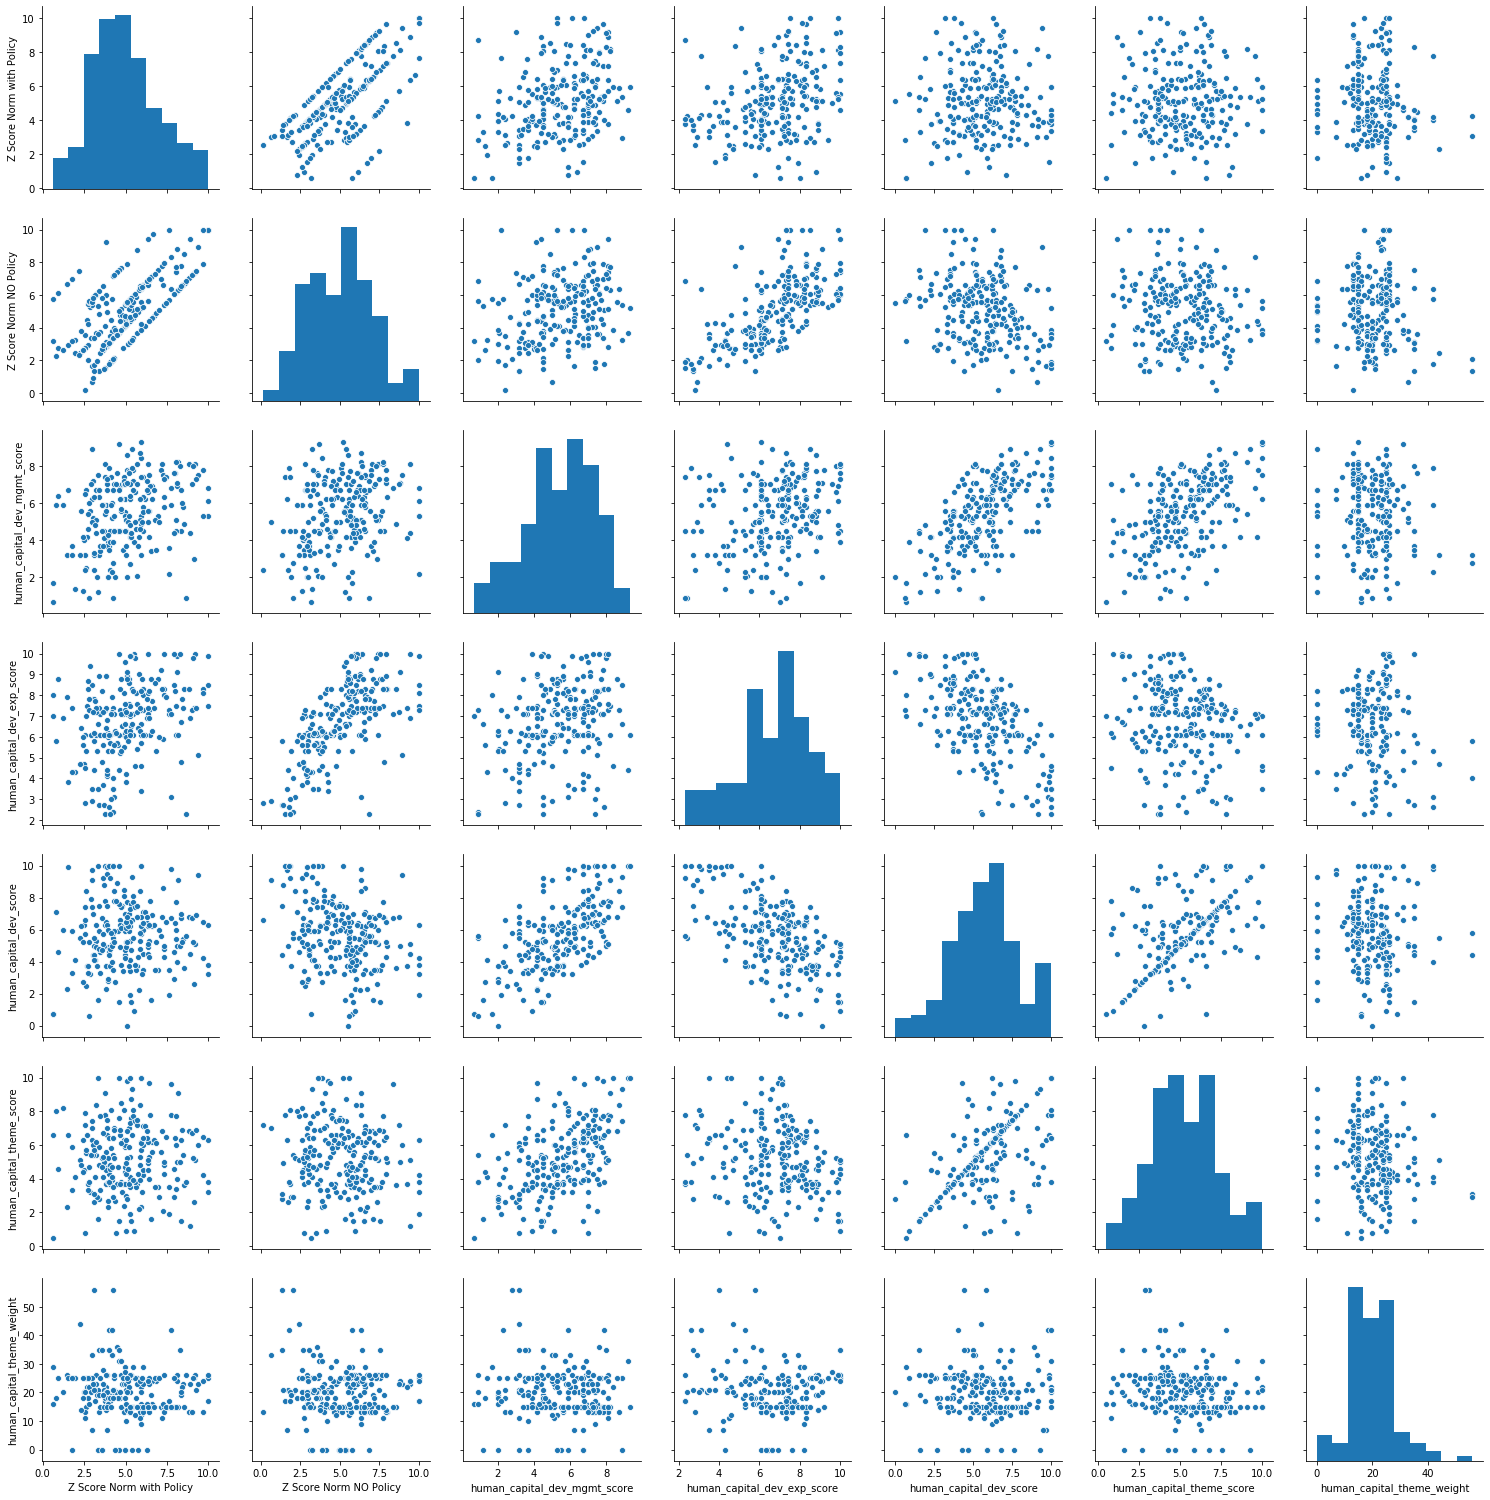

In [117]:
sns.pairplot(final_scores[["Z Score Norm with Policy", "Z Score Norm NO Policy", "human_capital_dev_mgmt_score", "human_capital_dev_exp_score", 
                          "human_capital_dev_score", "human_capital_theme_score", "human_capital_theme_weight"]], height=3)
plt.show()

In [118]:
final_scores["Investigate"] = abs(final_scores["human_capital_theme_score"] - final_scores["Z Score Norm with Policy"]) >= 3

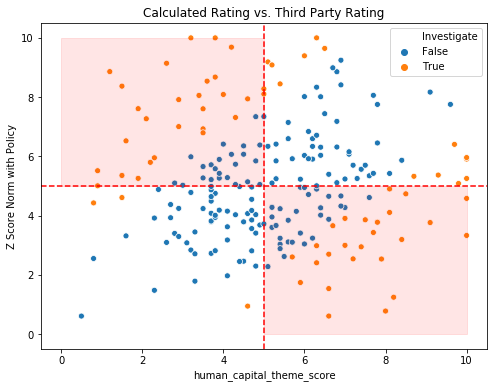

In [119]:
fig = plt.figure(figsize=(8,6))
sns.scatterplot(x="human_capital_theme_score", y="Z Score Norm with Policy", hue = "Investigate", data=final_scores)
plt.axhline(5, ls='--', c='red')

bottom_vals = np.linspace(0, 5, len(final_scores))
top_vals = np.linspace(5, 10, len(final_scores))

plt.gca().fill_between(bottom_vals, 5, 10, color='red', alpha=0.1)
plt.gca().fill_between(top_vals, 0, 5, color='red', alpha=0.1)

plt.axvline(5, ls='--', c='red')
plt.title("Calculated Rating vs. Third Party Rating")
plt.show()

In [120]:
problem_obs = final_scores[final_scores["Investigate"] == True]
good_obs = final_scores[final_scores["Investigate"] == False]

In [122]:
full_corr = final_scores[["Z Score Norm with Policy", "Z Score Norm NO Policy", "human_capital_dev_mgmt_score", "human_capital_dev_exp_score", "human_capital_dev_score", "human_capital_theme_score", "human_capital_theme_weight"]].corr()

good_corr = good_obs[["Z Score Norm with Policy", "Z Score Norm NO Policy", "human_capital_dev_exp_score", "human_capital_dev_score", "human_capital_theme_score", "human_capital_theme_weight"]].corr()

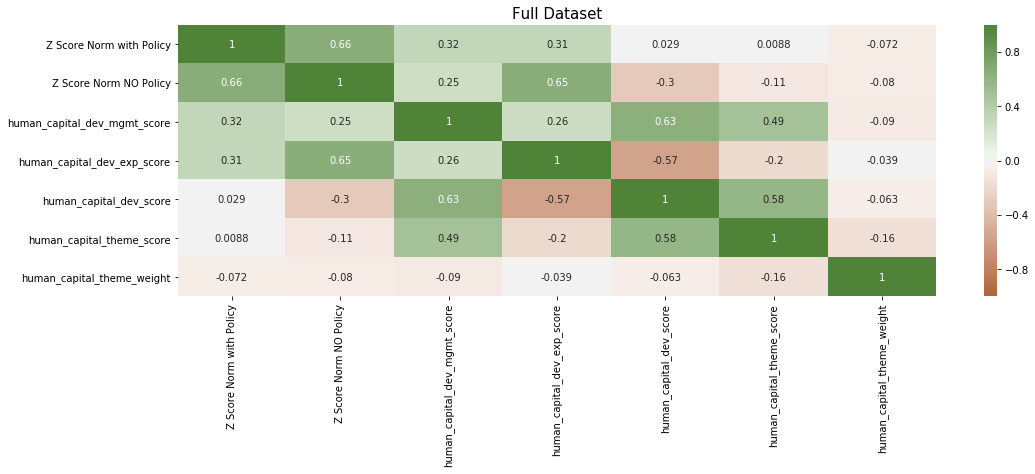

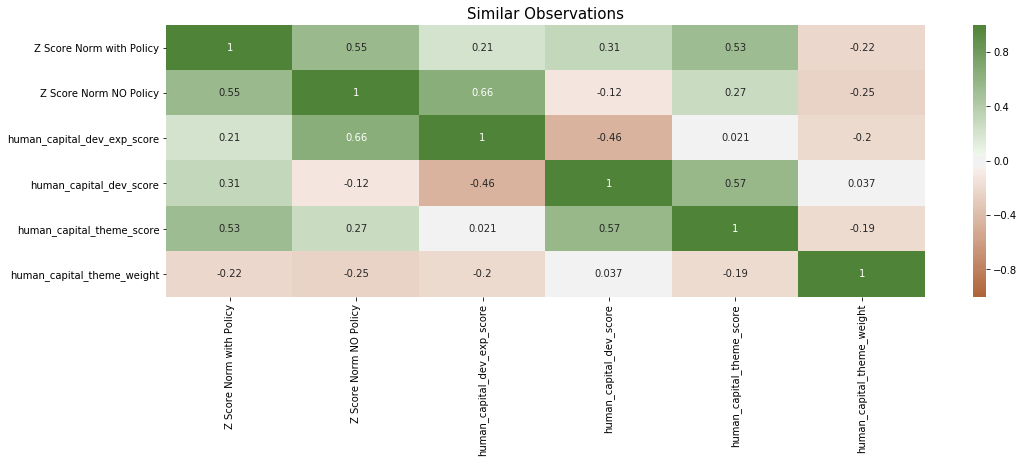

In [123]:
colors = sns.diverging_palette(30, 120, as_cmap=True)
plt.figure(figsize=(17, 5))
sns.heatmap(full_corr, cmap=colors, vmax = 1, vmin =-1, annot=True)
plt.title("Full Dataset", {"fontsize":15})
plt.show()

plt.figure(figsize=(17, 5))
sns.heatmap(good_corr, cmap=colors, vmax = 1, vmin =-1, annot=True)
plt.title("Similar Observations", {"fontsize":15})
plt.show()

In [136]:
np.round(problem_obs[["Z Score Norm with Policy", "Z Score Norm NO Policy", "human_capital_dev_exp_score", "human_capital_dev_score", "human_capital_theme_score", "human_capital_theme_weight"]].describe().T,2)

count   mean   std   min    25%    50%    75%  \
Z Score Norm with Policy      70.0   5.65  2.62  0.61   3.68   5.36   8.03   
Z Score Norm NO Policy        70.0   5.45  2.40  0.18   3.62   5.70   7.02   
human_capital_dev_exp_score   70.0   6.91  2.11  2.30   5.93   6.95   8.50   
human_capital_dev_score       70.0   5.75  2.54  0.70   4.05   5.65   7.48   
human_capital_theme_score     70.0   5.53  2.77  0.80   3.42   5.80   7.80   
human_capital_theme_weight    70.0  21.19  6.56  0.00  17.00  23.00  25.00   

                              max  
Z Score Norm with Policy     10.0  
Z Score Norm NO Policy       10.0  
human_capital_dev_exp_score  10.0  
human_capital_dev_score      10.0  
human_capital_theme_score    10.0  
human_capital_theme_weight   35.0

In [137]:
np.round(good_obs[["Z Score Norm with Policy", "Z Score Norm NO Policy", "human_capital_dev_exp_score", "human_capital_dev_score", "human_capital_theme_score", "human_capital_theme_weight"]].describe().T, 2)

count   mean   std   min    25%    50%    75%  \
Z Score Norm with Policy     167.0   4.79  1.68  0.61   3.64   4.71   5.88   
Z Score Norm NO Policy       167.0   4.87  1.84  0.88   3.33   4.87   6.28   
human_capital_dev_exp_score  155.0   6.66  1.63  2.30   5.90   7.10   7.80   
human_capital_dev_score      155.0   5.64  1.91  0.00   4.40   5.70   6.80   
human_capital_theme_score    155.0   5.10  1.60  0.50   3.85   5.10   6.30   
human_capital_theme_weight   155.0  19.61  9.11  0.00  15.00  18.00  24.00   

                               max  
Z Score Norm with Policy      9.25  
Z Score Norm NO Policy        9.76  
human_capital_dev_exp_score  10.00  
human_capital_dev_score      10.00  
human_capital_theme_score     9.60  
human_capital_theme_weight   56.00

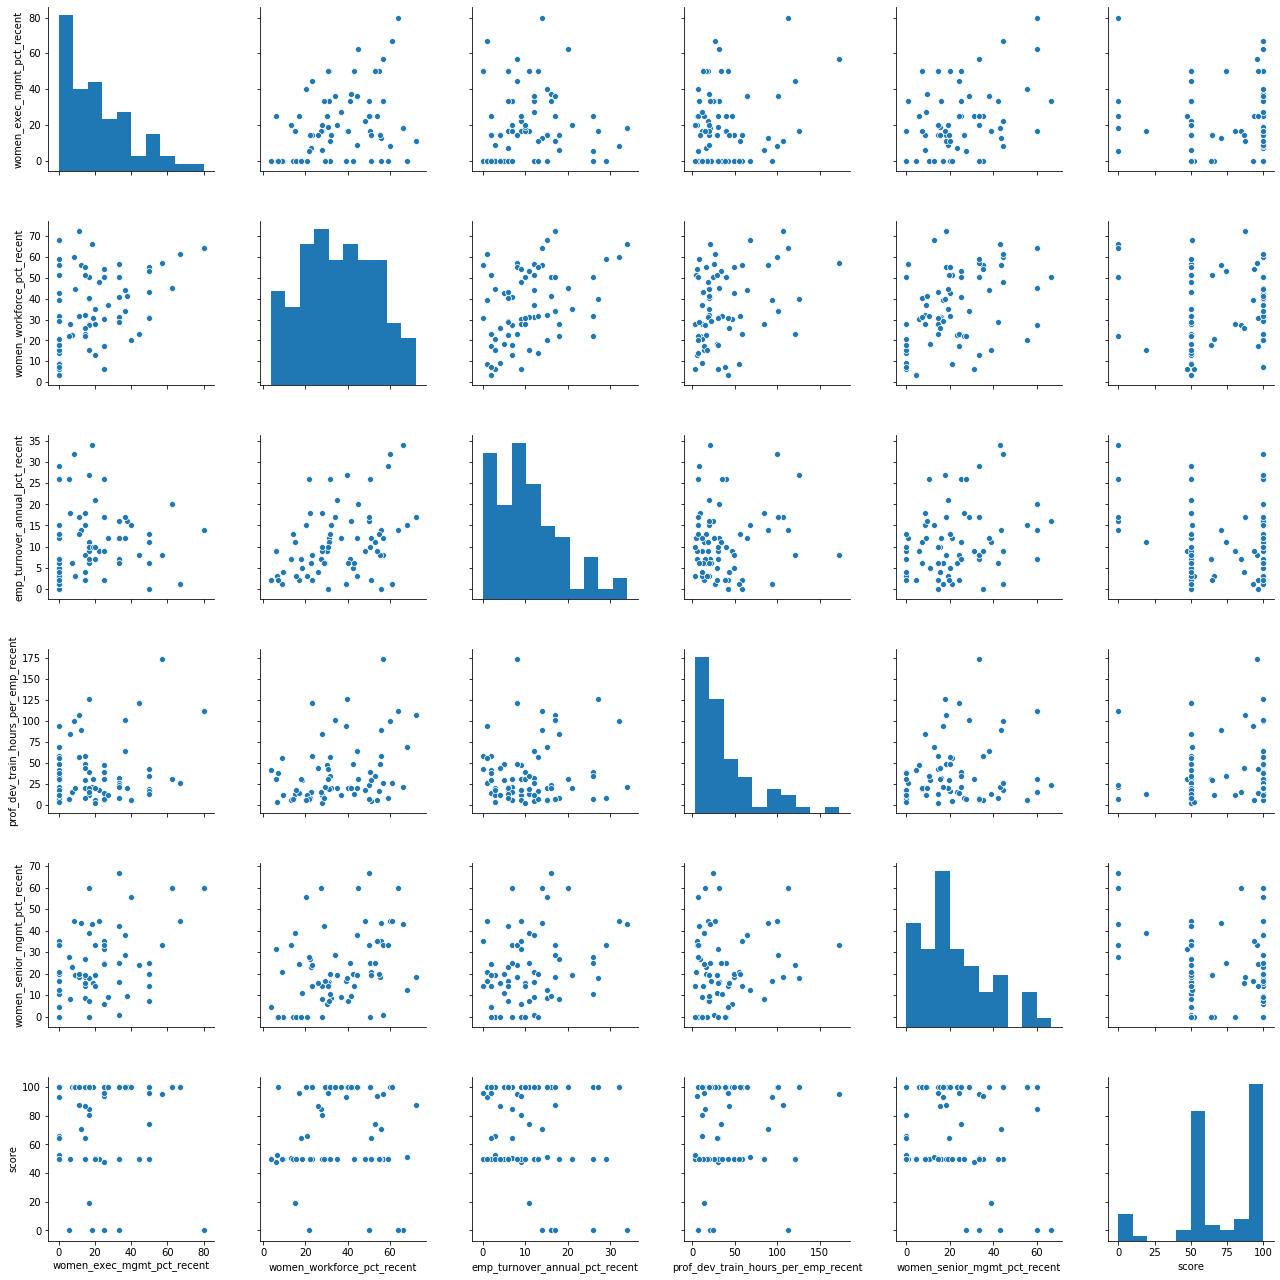

In [127]:
sns.pairplot(problem_obs[score_hcm_themes], height=3)
plt.show()

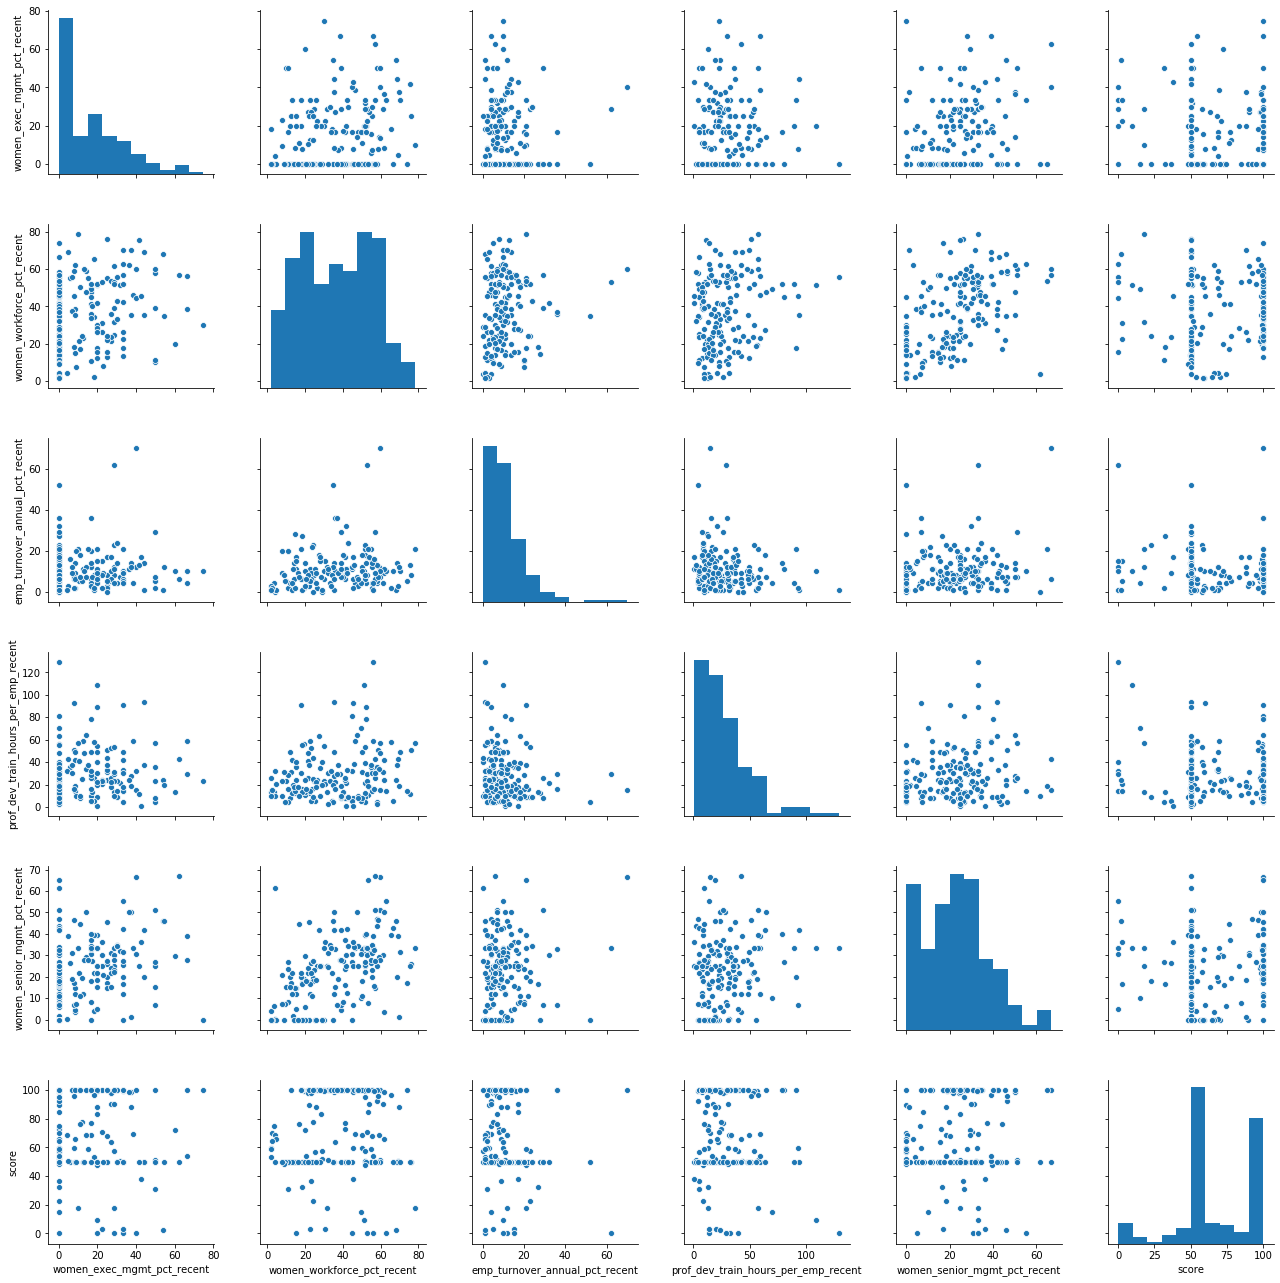

In [128]:
sns.pairplot(good_obs[score_hcm_themes], height=3)
plt.show()

In [126]:
#problem_obs.to_csv("observations_to_investigate_further.csv")
#final_scores.to_csv("full_final_output_data.csv")

## End of Python Jupyter Notebook